# Проект: вариант 3
Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

1) Был ли эксперимент успешен в целом.

2) Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

### План
**Шаг 1.** Загрузка, предобработка данных и EDA

**Шаг 2.** Формирование выводов из EDA и определение метрик для оценки результатов A/B теста

**Шаг 3.** A/A тест для проверки корректности работы системы сплитования

**Шаг 4.** Визуализация метрик в различных срезах, оценка результатов A/B теста

**Шаг 5.** Выводы и рекомендации по итогам проведённого эксперимента

### Импорт библиотек

In [1]:
# Для загрузки данных с Яндекс.Диска
import requests 
from urllib.parse import urlencode

# Для анализа данных
import pandas as pd
import numpy as np

# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
%matplotlib inline
sns.set(font_scale = 1.1, rc = {'figure.figsize': (10,5)})

# Для проверки статистических гипотез
from scipy import stats
import pingouin as pg

# Для удаления deprication-оповещений
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Загрузка данных A/B теста с помощью API Я.Диска
1) **users_test** – информация о пользователях в тестовой группе;

2) **users_control_1** – информация о пользователях в первой контрольной группе;

3) **users_control_2** – информация о пользователях во второй контрольной группе;

4) **transactions_test** – информация о платежах пользователей в тестовой группе;

5) **transactions_control_1** – информация о платежах пользователей в первой контрольной группе;

6) **transactions_control_2** – информация о платежах пользователей во второй контрольной группе

In [2]:
def disk_data_downloader(yandex_disk_key):
    public_key = yandex_disk_key

    # Получаем ссылку
    final_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' + urlencode(dict(public_key = public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл в датафрейм
    download_response = requests.get(download_url)
    df = pd.read_csv(download_url, sep = ';')
    return df

In [3]:
users_test      = disk_data_downloader('https://disk.yandex.ru/d/4XXIME4osGrMRA')
users_control_1 = disk_data_downloader('https://disk.yandex.ru/d/yJFydMNNGkEKfg')
users_control_2 = disk_data_downloader('https://disk.yandex.ru/d/br6KkQupzzTGoQ')

transactions_test      = disk_data_downloader('https://disk.yandex.ru/d/gvCWpZ55ODzs2g')
transactions_control_1 = disk_data_downloader('https://disk.yandex.ru/d/VY5W0keMX5TZBQ')
transactions_control_2 = disk_data_downloader('https://disk.yandex.ru/d/th5GL0mGOc-qzg')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### EDA
### Пользователи
users_test

In [4]:
users_test.info()
users_test.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.308000e+03,4308.000000,4308.000000,49.000000,4308,2978,4308.000000,4308.000000,4308.000000,4308.000000,408.0,157.0,4308.000000
unique,NaN,NaN,NaN,NaN,51,891,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,United States of America,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,1450,525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8.917437e+08,31.889276,316.411328,229.836735,NaN,NaN,0.953110,26.701486,38.248839,50.391133,1.0,1.0,534.080316
std,4.547670e+05,10.245287,323.373725,1205.819471,NaN,NaN,0.211427,9.390851,15.344562,318.676437,0.0,0.0,4371.682632
min,8.910511e+08,16.000000,0.000000,1.000000,NaN,NaN,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913621e+08,25.000000,0.000000,4.000000,NaN,NaN,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917290e+08,30.000000,250.000000,9.000000,NaN,NaN,1.000000,24.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920952e+08,38.000000,520.250000,72.000000,NaN,NaN,1.000000,32.000000,44.000000,22.000000,1.0,1.0,0.000000


Всего 408 пользователей в тесте когда-либо оформляли премиум-подписку, 157 из них подписаны сейчас

In [5]:
users_test.gender.value_counts(normalize=True)

1    0.95311
0    0.04689
Name: gender, dtype: float64

Среди пользователей сервиса в тесте, скорее всего, значительно больше мужчин ("1") - 95% от общего кол-ва

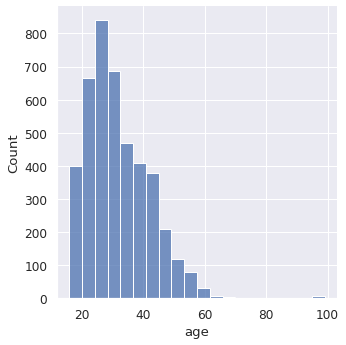

In [6]:
ax = sns.displot(users_test['age'], kde = False, bins = 20)

Распределение возраста сильно смещено, при наличии выбросов в правой части распределения

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


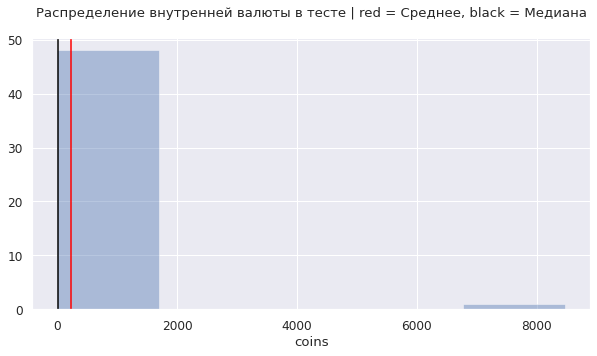

In [7]:
ax = sns.distplot(users_test['coins'], kde = False, bins = 5)
ax.set(title = 'Распределение внутренней валюты в тесте | red = Среднее, black = Медиана\n')
plt.axvline(x = users_test['coins'].mean(), color = 'red')
plt.axvline(x = users_test['coins'].median(), color = 'black')
plt.show()

Всего 49 пользователей из 4308 в тесте имеют внутреннюю валюту

In [8]:
users_test.nlargest(3, 'coins')['coins']

2937    8466.0
597      530.0
406      378.0
Name: coins, dtype: float64

В тесте есть один выброс с 8466 монетами, что серьёзно искажает распределение внутренней валюты

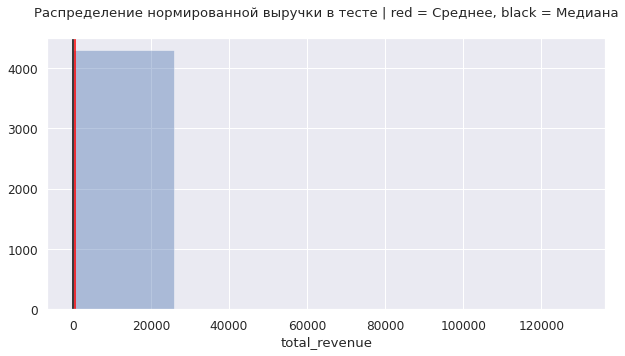

In [9]:
ax = sns.distplot(users_test['total_revenue'], kde = False, bins = 5)
ax.set(title = 'Распределение нормированной выручки в тесте | red = Среднее, black = Медиана\n')
plt.axvline(x = users_test['total_revenue'].mean(), color = 'red')
plt.axvline(x = users_test['total_revenue'].median(), color = 'black')
plt.show()

По показателю total_revenue есть несколько выбросов, распределение также сильно смещено

In [10]:
users_test.nlargest(7, 'total_revenue')['total_revenue']

3629    129870
992     123565
406      95823
597      75647
1316     61789
2642     47242
3323     38779
Name: total_revenue, dtype: int64

In [11]:
users_test[users_test['was_premium'].isna()].query("total_revenue != 0")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
35,892333656,50,436,4.0,United States of America,"1,2,3,4",1,47,53,126,NaN,NaN,897
280,891914511,30,500,4.0,Switzerland,1,1,18,43,2,NaN,NaN,1508
530,891914322,35,500,6.0,United States of America,"1,2,3,4,5,6,7,8,9",1,32,38,48,NaN,NaN,741
968,891999783,30,793,6.0,United States of America,"1,2,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20...",1,27,33,29,NaN,NaN,3783
2895,891632079,30,100,9.0,United States of America,"5,6",1,27,33,20,NaN,NaN,4537
3997,891175326,29,666,6.0,United States of America,"1,2,3,5,7",1,26,32,3,NaN,NaN,897


Помимо премиум-подписки в сервисе есть еще одна или несколько других механик монетизации (как узнаём при EDA таблиц *transactions* - это подписки за внутреннюю валюту (coins) и другое (other_type)), поскольку существуют записи пользователей, с которых была получена выручка, но они не оформляли премиум-подписок)

In [12]:
users_test.country.value_counts(normalize=True).head()

United States of America    0.336583
Argentina                   0.091922
France                      0.083333
Italy                       0.074977
Spain                       0.069870
Name: country, dtype: float64

В лидерах по кол-ву пользователей - США, Аргентина и страны ЕС

При постановке задачи сообщается, что изменения в стоимости премиум-подписки были раскатаны только для пользователей из нескольких стран. Посмотрим, релевантно ли отделять пользователей только из этих стран для оценки результатов A/B теста

In [13]:
print(f'Кол-во уникальных стран в тесте: {users_test.country.nunique()}')
print(f'Кол-во уникальных стран в контроле 1: {users_control_1.country.nunique()}')
print(f'Кол-во уникальных стран в контроле 2: {users_control_2.country.nunique()}')

Кол-во уникальных стран в тесте: 51
Кол-во уникальных стран в контроле 1: 40
Кол-во уникальных стран в контроле 2: 45


In [14]:
test_country_list = users_test.country.unique().tolist()

users_control_1[~users_control_1['country'].isin(test_country_list)]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
368,892208838,46,375,NaN,Venezuela,NaN,1,43,49,8,NaN,NaN,0
796,891197604,35,333,NaN,Sweden,"1,2,3,4,5,7,8",1,32,38,27,NaN,NaN,0
933,891395712,38,755,NaN,Panama,"1,2,3,4,6,7,8,9,10",1,17,45,49,NaN,NaN,0
1303,892317243,37,333,NaN,China,"1,2,3,4",1,34,40,30,NaN,NaN,0
1687,891669081,53,579,NaN,Armenia,"1,2,3,5",1,16,99,1059,NaN,NaN,0
2039,891226011,35,0,NaN,Venezuela,"1,2",1,32,90,3,NaN,NaN,0
2889,892238886,32,152,NaN,"Moldova, Republic of","1,2,3,23",1,18,39,72,NaN,NaN,0
2911,891631011,25,1000,NaN,Jamaica,"1,2,3,4",1,22,28,1,NaN,NaN,0
3582,891672090,27,700,NaN,Burkina Faso,"1,2,3,4,5,6,7,8,9,10,11,12,13",1,17,23,20,NaN,NaN,0
3623,892437114,26,214,NaN,Qatar,1,1,23,29,14,NaN,NaN,0


In [15]:
users_control_2[~users_control_2['country'].isin(test_country_list)]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
282,892011714,29,55,NaN,China,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,26,39,18,NaN,NaN,0
676,891787275,29,800,NaN,Austria,NaN,1,26,32,20,NaN,NaN,0
2195,891894243,90,714,NaN,New Zealand,1,1,50,70,7,NaN,NaN,0
2361,891856803,28,58,NaN,Malaysia,1,1,25,31,17,NaN,NaN,0
2478,891104472,35,391,NaN,Mali,"1,2,3,4,5",1,38,80,23,NaN,NaN,0
2533,891243849,18,0,NaN,Nicaragua,1,1,18,38,0,NaN,NaN,0
2706,891863451,24,49,NaN,Belarus,"1,2,3,4,5,7,8,9,10,11,12,13,14,15,16",1,20,27,81,NaN,NaN,0
2709,891545943,27,782,NaN,Czech Republic,1,0,29,43,207,NaN,NaN,0
3010,892129620,34,500,NaN,Uganda,"1,2,3,4,5",1,31,37,2,NaN,NaN,0
3138,892134624,49,921,NaN,Kuwait,"1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...",1,16,99,3448,NaN,NaN,0


Есть суммарно 25 пользователей в контрольных подвыборках, страны которых не совпадают со странами, представленными в тестовой группе. При этом мы не можем со 100%-ой точностью утверждать, что страны этих 25 пользователей не участвовали в эксперименте - они вполне могли быть его частью, но конкретные пользователи попали только в контрольные подвыборки из-за небольшой представленности этих стран в сервисе.

По этой причине у нас нет достаточных оснований убирать данные этих пользователей перед оценкой результатов A/B теста.

users_control_1

In [16]:
users_control_1.info()
users_control_1.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.340000e+03,4340.000000,4340.000000,60.0000,4340,3016,4340.000000,4340.000000,4340.000000,4340.000000,436.0,192.0,4340.000000
unique,NaN,NaN,NaN,NaN,40,880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,United States of America,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,1471,592,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8.917578e+08,32.095392,312.048848,1745.9000,NaN,NaN,0.958065,26.793779,38.553226,44.467512,1.0,1.0,594.761982
std,1.125683e+06,10.257466,320.972130,12902.3577,NaN,NaN,0.200465,9.405103,15.226951,204.800272,0.0,0.0,7987.922925
min,8.910510e+08,16.000000,0.000000,1.0000,NaN,NaN,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913626e+08,24.000000,0.000000,8.0000,NaN,NaN,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917272e+08,30.000000,238.500000,11.5000,NaN,NaN,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920898e+08,38.000000,518.000000,28.0000,NaN,NaN,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000


Кол-во текущих и all-time пользователей премимум-подписки в контрольной группе 1 немного выше, чем в тесте

In [17]:
users_control_1.gender.value_counts(normalize=True)

1    0.958065
0    0.041935
Name: gender, dtype: float64

Схожее с тестовой группой распределение возрастов пользователей

In [18]:
users_control_1.nlargest(4, 'coins')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
510,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330
475,891989511,25,166,110.0,United States of America,"1,2,3",1,16,54,6,1.0,NaN,12389
1925,891452706,41,134,80.0,Italy,"1,2,3,6,8,11",1,38,44,82,1.0,1.0,18902


В первой контрольной группе также присутствуют выбросы (как минимум 2) с очень высокими показателями внутренней валюты и несколько выбросов по нормированной выручке, распределения этих величин также сильно смещены

In [19]:
users_control_1.nlargest(7, 'total_revenue')['total_revenue']

1427    486330
2296     64298
874      63037
1815     63024
284      60333
2964     59267
2022     29081
Name: total_revenue, dtype: int64

Подтверждаем ранее выдвинутую гипотезу о наличии в сервисе нескольких механик монетизации: это точно *не* баг в данных тестовой подвыборки, поскольку в первом контроле пользователи, приносящие выручку, но не оформившие премиум-подписку, также есть.

In [20]:
users_control_1[users_control_1['was_premium'].isna()].query("total_revenue != 0")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
5,891497961,28,400,28.0,Chile,"1,2",1,25,31,25,NaN,NaN,6396
532,891960267,27,0,28.0,Italy,NaN,1,24,30,0,NaN,NaN,3952
644,891792453,18,0,8.0,Australia,"1,2,3,4,5,6,7,8,9,10,11,13,14,15,16",1,18,21,0,NaN,NaN,1313
801,891135642,47,200,1.0,Chile,"1,2,3,4,5,6",1,40,46,165,NaN,NaN,962
1079,892140927,27,0,28.0,France,NaN,1,24,30,0,NaN,NaN,3965
1756,892104378,32,620,22.0,United States of America,"1,2,3",1,29,35,58,NaN,NaN,4602
2665,891867801,24,444,10.0,Israel,1,1,21,30,9,NaN,NaN,6305
2964,892069554,47,185,8.0,United Kingdom (Great Britain),"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,38,1414,NaN,NaN,59267
2998,891653790,24,500,6.0,Italy,"1,2,3,4,5,7,8,9,10,11,12,13,14,15,16",1,29,61,4,NaN,NaN,728
3293,891668241,29,0,28.0,United States of America,NaN,1,37,50,0,NaN,NaN,6305


In [21]:
users_control_1.country.value_counts(normalize=True).head()

United States of America    0.338940
Argentina                   0.089631
France                      0.085253
Spain                       0.078802
Italy                       0.077880
Name: country, dtype: float64

Топ-5 стран по кол-ву пользователей абсолютно идентичен с тестовой подвыборкой

users_control_2

In [22]:
users_control_2.info()
users_control_2.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.264000e+03,4264.000000,4264.000000,61.000000,4264,2900,4264.000000,4264.000000,4264.000000,4264.000000,411.0,191.0,4264.000000
unique,NaN,NaN,NaN,NaN,45,837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,United States of America,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,1486,587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8.917694e+08,32.046201,317.957317,18.147541,NaN,NaN,0.954268,26.954268,38.906895,45.064493,1.0,1.0,450.384146
std,2.520759e+06,10.170721,326.191737,35.439543,NaN,NaN,0.208927,9.546657,15.955574,318.188992,0.0,0.0,2859.242228
min,8.910509e+08,16.000000,0.000000,1.000000,NaN,NaN,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913453e+08,25.000000,0.000000,4.000000,NaN,NaN,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917205e+08,30.000000,250.000000,10.000000,NaN,NaN,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920735e+08,38.000000,548.500000,20.000000,NaN,NaN,1.000000,32.000000,45.000000,20.000000,1.0,1.0,0.000000


In [23]:
users_control_2.gender.value_counts(normalize=True)

1    0.954268
0    0.045732
Name: gender, dtype: float64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


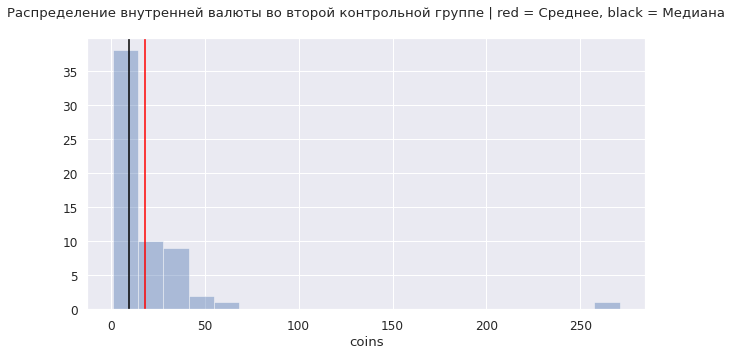

In [24]:
ax = sns.distplot(users_control_2['coins'], kde = False, bins = 20)
ax.set(title = 'Распределение внутренней валюты во второй контрольной группе | red = Среднее, black = Медиана\n')
plt.axvline(x = users_control_2['coins'].mean(), color = 'red')
plt.axvline(x = users_control_2['coins'].median(), color = 'black')
plt.show()

Несмотря на наличие смещённости у распределения, во второй контрольной группе нет таких сильных выбросов по внутренней валюте, как в тесте и первой контрольной группе. В остальном распределения похожи. По нормированной выручке ситуация с выбросами во всех трёх группах идентичная

In [25]:
users_control_2.nlargest(7, 'total_revenue')['total_revenue']

1360    81796
1216    75647
1656    34125
1265    30849
892     28119
3860    27729
940     23712
Name: total_revenue, dtype: int64

In [26]:
users_control_2[users_control_2['was_premium'].isna()].query("total_revenue != 0")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
5,892197879,28,71,NaN,Italy,1,1,25,31,14,NaN,NaN,2522
643,892009254,21,0,NaN,Italy,"1,3,4,5,6,7",1,18,24,0,NaN,NaN,7072
765,891317289,29,333,2.0,Chile,"1,2,3,4,5,6,7,8",1,21,32,12,NaN,NaN,481
855,891232197,32,243,1.0,Italy,"1,2",1,29,35,82,NaN,NaN,3900
1044,891662685,39,272,NaN,France,11,1,36,42,11,NaN,NaN,2717
1720,892345869,23,1000,NaN,Chile,1,1,20,26,4,NaN,NaN,2457
1781,891841752,22,541,NaN,United States of America,"1,2,3,4,5,6,7,10,11,12,13,14,15,16,18",1,19,25,179,NaN,NaN,1586
1833,891260820,24,318,NaN,United States of America,"1,2,3,4,5,6,7,8,9",1,21,27,22,NaN,NaN,897
2408,892069761,16,90,16.0,Argentina,"1,2,3",1,16,20,11,NaN,NaN,6305
3874,891750606,46,395,4.0,France,"1,2,3,4,5,6,7,8,9,10,11,12,13,15,16",1,43,49,291,NaN,NaN,7813


In [27]:
users_control_2.country.value_counts(normalize=True).head()

United States of America    0.348499
Argentina                   0.093105
France                      0.088180
Spain                       0.072702
Italy                       0.068715
Name: country, dtype: float64

### Платежи
Будем считать данные в столбцах revenue таблиц *transactions* за суммы каждого отдельного платежа, которые пользователи заплатили за покупку определённого типа продукта, в т.ч. премиум-подписок

transactions_test

In [28]:
transactions_test.info()
transactions_test.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
count,2.730000e+02,273,273,273,273.000000,273.000000,273,273
unique,NaN,17,146,258,NaN,NaN,22,4
top,NaN,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,NaN,NaN,empty_likes,coins
freq,NaN,94,14,4,NaN,NaN,72,106
mean,8.918375e+08,NaN,NaN,NaN,8589.380952,98.227106,NaN,NaN
std,3.777452e+05,NaN,NaN,NaN,11127.479971,57.762760,NaN,NaN
min,8.910712e+08,NaN,NaN,NaN,533.000000,0.000000,NaN,NaN
25%,8.915082e+08,NaN,NaN,NaN,2743.000000,19.000000,NaN,NaN
50%,8.919143e+08,NaN,NaN,NaN,6305.000000,146.000000,NaN,NaN
75%,8.921442e+08,NaN,NaN,NaN,12597.000000,147.000000,NaN,NaN


Необходимо сконвертировать столбцы с датами (joined_at, paid_at) в тип данных datetime

In [29]:
transactions_test[['joined_at', 'paid_at']] = transactions_test[['joined_at', 'paid_at']] \
    .apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

In [30]:
transactions_test.uid.nunique()

146

Пользователи, представленные в таблицах с платежами, не уникальны - логично, ведь один пользователь мог сделать несколько транзакций за указанный период

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


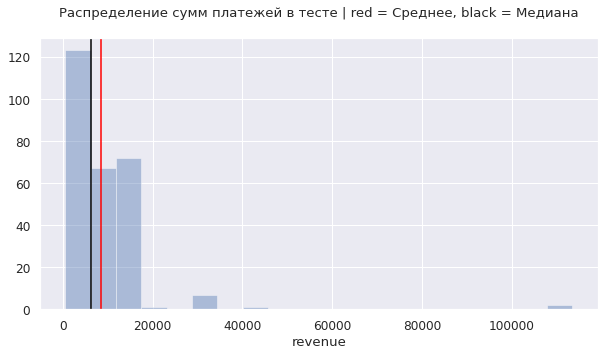

In [31]:
ax = sns.distplot(transactions_test['revenue'], kde = False, bins = 20)
ax.set(title = 'Распределение сумм платежей в тесте | red = Среднее, black = Медиана\n')
plt.axvline(x = transactions_test['revenue'].mean(), color = 'red')
plt.axvline(x = transactions_test['revenue'].median(), color = 'black')
plt.show()

Распределение сумм платежей сильно смещено, наблюдаем несколько выбросов в правой части распределения

In [32]:
transactions_test.from_page.value_counts()

empty_likes            72
trial_vip_popup        48
none                   34
autoreply_message      27
menu                   27
promo_09               18
popular_users_chat     10
left_sidebar_menu       7
dating                  5
autorefill              5
fans                    4
gifts                   3
super_popup             2
sympathy                2
popular_users_block     2
send_message            1
empty_mutual            1
delivery_vip            1
ad_to_photo             1
user_profile            1
likes                   1
coins_popup             1
Name: from_page, dtype: int64

In [33]:
transactions_test.from_page.nunique()

22

Наблюдаем более 20 групп по критерию страницы, с которой пользователь переходил на страницу оплаты перед совершением транзакции. Отмечаем: по этому критерию будет очень сложно сегментировать пользователей при оценке результатов A/B теста

In [34]:
transactions_test.groupby('product_type').agg({'uid': 'count', 'uid': 'nunique', 'revenue': 'mean'})

,uid,revenue
product_type,,
coins,52,5341.283019
other_type,19,5786.793103
premium_no_trial,67,10667.184211
trial_premium,61,12906.483871


### Описание типов продукта
*trial_premium* – пробная премиум-подписка

*premium_no_trial* – премиум-подписка без пробной

*coins* – подписка за внутреннюю валюту

*other_type* – другое

In [35]:
trans_test_coins = transactions_test[transactions_test['product_type'] == 'coins']
trans_test_coins.describe()

,uid,revenue,payment_id
count,1.060000e+02,106.000000,106.000000
mean,8.918762e+08,5341.283019,54.943396
std,3.530873e+05,7342.639039,57.480900
min,8.911753e+08,533.000000,19.000000
25%,8.915665e+08,936.000000,19.000000
50%,8.919998e+08,3536.000000,19.000000
75%,8.921376e+08,6305.000000,146.000000
max,8.924341e+08,31525.000000,146.000000


Премиум-подписки за внутреннюю валюту, видимо, могут быть оплачены внутренней валютой только частично: каждая такая подписка генерирует какую-либо выручку (на примере тестовой группы, в диапазоне от 533 до 31525 за одну оплату подписки)

### Важное примечание по типам продукта
Несмотря на то, что прямое отношение к эксперименту имеют только изменения в выручке и конверсиях по непробной премиум-подписке (т.к. согласно поставленной задаче её стоимость была изменена, а стоимость пробной не изменилась), изменения в её стоимости могут косвенно влиять на конверсии в целевое действие и выручку по другим типам продукта.

Например, если стоимость подписки снижена, пользователи, вероятно, станут чаще оформлять пробную подписку, поскольку она в среднем дешевле основной (следует из таблицы с группировкой по типам продукта выше), а потом уже с определённым retention переходить на основную подписку по её сравнительно сниженной стоимости. Пользователя также может заинтересовать возможность сперва оформить подписку за внутренную валюту при наличии монет, а потом продолжить пользоваться премиум-фичами по сниженной цене. Это же может быть применимо к другим типам продукта и работает в обратную сторону в случае повышения стоимости подписки.

Именно для проверки такого рода гипотез и включения финансового эффекта от "других типов продукта" в последующую интерпретацию результатов A/B теста стоит включить все типы подписки.

In [36]:
print(transactions_test['joined_at'].min(), transactions_test['joined_at'].max())
print(transactions_test['paid_at'].min(), transactions_test['paid_at'].max())

2017-01-11 03:07:00 2017-10-31 23:40:00
2017-01-11 04:37:00 2017-12-11 22:06:00


In [37]:
early_pay = transactions_test[transactions_test['joined_at'] > transactions_test['paid_at']]

print(early_pay.shape)
early_pay.head()

(47, 8)


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
11,891861048,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial
20,891806280,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242,147,trial_vip_popup,trial_premium
24,891786216,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818,147,trial_vip_popup,trial_premium
25,892057347,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209,19,none,coins
36,891589239,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305,19,empty_likes,coins


По какой-то причине в ряде записей (47 строк) в тесте дата проведения платежа стоит раньше даты регистрации пользователя. Одна из дат могла записаться неправильно при логировании. Пробежавшись по всем таким случаям, отмечаем, что все регистрации и платежи в любом случае относятся к временному отрезку, в который проводился эксперимент - удалять эти строки из-за обнаруженного бага с датами нет смысла.

In [38]:
transactions_test \
    .query("product_type == 'premium_no_trial'") \
    .groupby('country', as_index=False) \
    .agg({'revenue': 'nunique', 'payment_id': 'nunique'})

,country,revenue,payment_id
0,Argentina,3,1
1,Australia,1,1
2,Belgium,1,1
3,Canada,3,2
4,Chile,6,1
5,France,5,1
6,Germany,2,2
7,Israel,1,1
8,Italy,5,2
9,Latvia,1,1


Исходя из тестовых данных, разница в стоимости премиум-подписок не зависит от страны проведения оплаты и не подвязывается к определённому *payment_id*. Возможно, цена подписок формируется по механике, информация о которой не включена в таблицы с платежами.

transactions_control_1

In [39]:
transactions_control_1.info()
transactions_control_1.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
count,3.770000e+02,377,1007,1007,377.000000,377.000000,377,377
unique,NaN,18,194,336,NaN,NaN,25,4
top,NaN,United States of America,NaT,NaT,NaN,NaN,empty_likes,coins
freq,NaN,105,630,630,NaN,NaN,99,149
mean,8.923612e+08,NaN,NaN,NaN,6929.206897,91.145889,NaN,NaN
std,6.162900e+06,NaN,NaN,NaN,8027.889630,58.599773,NaN,NaN
min,8.910923e+08,NaN,NaN,NaN,26.000000,0.000000,NaN,NaN
25%,8.913833e+08,NaN,NaN,NaN,2730.000000,19.000000,NaN,NaN
50%,8.918225e+08,NaN,NaN,NaN,6266.000000,127.000000,NaN,NaN
75%,8.921850e+08,NaN,NaN,NaN,6448.000000,147.000000,NaN,NaN


In [40]:
transactions_control_1[['joined_at', 'paid_at']] = transactions_control_1[['joined_at', 'paid_at']] \
    .apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

In [41]:
transactions_control_1.uid.nunique()

193

Скорее всего, при записи платежей части пользователей первой контрольной группы произошёл баг: есть лог даты их присоединения и платежа, но какие-либо другие данные отсутствуют. Уберём пустые строки из таблицы users_control_1 и посмотрим на данные заново

In [42]:
transactions_control_1 = transactions_control_1[transactions_control_1['uid'].notna()]
transactions_control_1.describe(include='all')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
count,3.770000e+02,377,377,377,377.000000,377.000000,377,377
unique,NaN,18,193,335,NaN,NaN,25,4
top,NaN,United States of America,2017-10-16 01:38:00,2017-10-16 02:08:00,NaN,NaN,empty_likes,coins
freq,NaN,105,27,5,NaN,NaN,99,149
first,NaN,NaN,2015-01-19 11:49:00,2016-12-14 16:16:00,NaN,NaN,NaN,NaN
last,NaN,NaN,2017-10-31 22:17:00,2017-12-11 21:57:00,NaN,NaN,NaN,NaN
mean,8.923612e+08,NaN,NaN,NaN,6929.206897,91.145889,NaN,NaN
std,6.162900e+06,NaN,NaN,NaN,8027.889630,58.599773,NaN,NaN
min,8.910923e+08,NaN,NaN,NaN,26.000000,0.000000,NaN,NaN
25%,8.913833e+08,NaN,NaN,NaN,2730.000000,19.000000,NaN,NaN


Среднее по выручке с платежа значительно ниже в контроле, но медианы распределений сильно не различаются. Это приводит нас к предположению, что цену на премиум подписку в тесте могли изменить в большую сторону

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


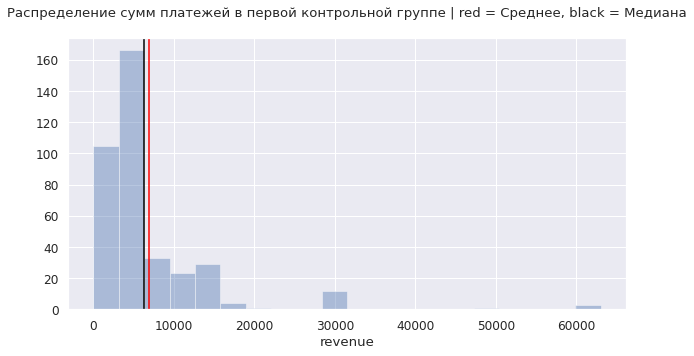

In [43]:
ax = sns.distplot(transactions_control_1['revenue'], kde = False, bins = 20)
ax.set(title = 'Распределение сумм платежей в первой контрольной группе | red = Среднее, black = Медиана\n')
plt.axvline(x = transactions_control_1['revenue'].mean(), color = 'red')
plt.axvline(x = transactions_control_1['revenue'].median(), color = 'black')
plt.show()

Распределение сумм платежей также сильно смещено, нет серьёзных отличий с тестом

In [44]:
transactions_control_1.groupby('product_type').agg({'uid': 'count', 'revenue': 'mean'})

,uid,revenue
product_type,,
coins,149,5851.744966
other_type,55,3425.854545
premium_no_trial,106,7351.500000
trial_premium,67,11533.134328


Средние сумм платежей по типам продуктов и конверсии визуально расходятся с тем, что было в тестовой подвыборке. Обязательно добавим сегментацию пользователей по типам приобретённого ими продукта в финальной версии таблицы, подготовленной для интерпретации эксперимента

In [45]:
print(transactions_control_1['joined_at'].min(), transactions_control_1['joined_at'].max())
print(transactions_control_1['paid_at'].min(), transactions_control_1['paid_at'].max())

2015-01-19 11:49:00 2017-10-31 22:17:00
2016-12-14 16:16:00 2017-12-11 21:57:00


In [46]:
transactions_control_1[transactions_control_1['joined_at'] < '2017-01-11 00:00:00']

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type


### Важное примечание по времени проведения эксперимента
Наблюдаем, что в первую контрольную групп случайно попал пользователь, который делал платежи до 11 января 2017 года, что, судя по тестовой и второй контрольной подвыборке, являлось датой начала проведения эксперимента.

Известно, что измерения для обоих групп A/B теста необходимо проводить в один момент времени для избежания влияния внешних факторов (в случае дейтингового приложения это может быть, например, сезонность) на результаты исследования. В данном случае это не соблюдается, поэтому записи, сделанные до 11 января 2017 года, необходимо удалить.

In [47]:
transactions_control_1 = transactions_control_1[transactions_control_1['joined_at'] > '2017-01-11 00:00:00']
transactions_control_1.shape # Убрали три строки

(374, 8)

In [48]:
early_pay_1 = transactions_control_1[transactions_control_1['joined_at'] > transactions_control_1['paid_at']]

print(early_pay_1.shape)
early_pay_1.head()

(55, 8)


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
5,891721851.0,United States of America,2017-10-29 02:50:00,2017-05-11 07:15:00,4602.0,146.0,empty_likes,coins
14,892277877.0,United States of America,2017-10-17 03:36:00,2017-10-11 15:23:00,897.0,19.0,empty_likes,coins
20,892366260.0,United Kingdom (Great Britain),2017-10-15 15:04:00,2017-09-11 20:06:00,6305.0,19.0,autorefill,coins
21,891707061.0,Argentina,2017-10-29 10:54:00,2017-04-11 00:30:00,1261.0,19.0,empty_likes,coins
23,891707061.0,Argentina,2017-10-29 10:54:00,2017-10-11 00:04:00,1261.0,19.0,autorefill,coins


Баг с датами покупки и оплаты есть и в первой контрольной группе. Такое ощущение, что при логировании пользователям неверно присвоили дату регистрации в октябре. Тем не менее, снова игнорируем этот баг, но отмечаем, что данные по дате регистрации для сегментации пользователей использовать необъективно.

transactions_control_2

In [49]:
transactions_control_2.info()
transactions_control_2.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           328 non-null    int64 
 1   country       328 non-null    object
 2   joined_at     328 non-null    object
 3   paid_at       328 non-null    object
 4   revenue       328 non-null    int64 
 5   payment_id    328 non-null    int64 
 6   from_page     328 non-null    object
 7   product_type  328 non-null    object
dtypes: int64(3), object(5)
memory usage: 20.6+ KB


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
count,3.280000e+02,328,328,328,328.000000,328.000000,328,328
unique,NaN,19,187,309,NaN,NaN,18,4
top,NaN,United States of America,2017-10-30 15:22:00,2017-10-23 20:17:00,NaN,NaN,empty_likes,coins
freq,NaN,107,11,3,NaN,NaN,101,124
mean,8.918121e+08,NaN,NaN,NaN,5854.993902,95.527439,NaN,NaN
std,3.802149e+05,NaN,NaN,NaN,6582.242539,57.247832,NaN,NaN
min,8.910681e+08,NaN,NaN,NaN,481.000000,0.000000,NaN,NaN
25%,8.915738e+08,NaN,NaN,NaN,2323.750000,19.000000,NaN,NaN
50%,8.918626e+08,NaN,NaN,NaN,4706.000000,146.000000,NaN,NaN
75%,8.921281e+08,NaN,NaN,NaN,6314.750000,147.000000,NaN,NaN


In [50]:
transactions_control_2[['joined_at', 'paid_at']] = transactions_control_2[['joined_at', 'paid_at']] \
    .apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

In [51]:
transactions_control_2.uid.nunique()

187

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


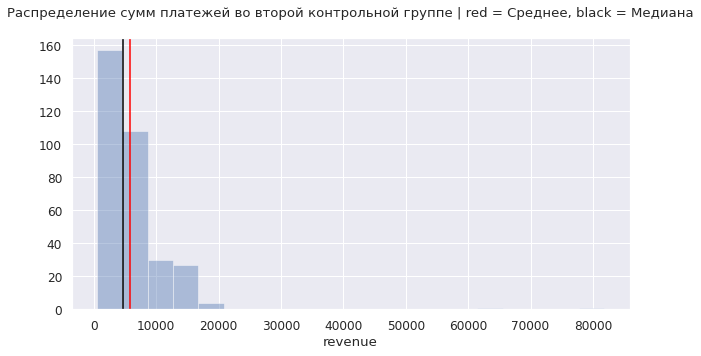

In [52]:
ax = sns.distplot(transactions_control_2['revenue'], kde = False, bins = 20)
ax.set(title = 'Распределение сумм платежей во второй контрольной группе | red = Среднее, black = Медиана\n')
plt.axvline(x = transactions_control_2['revenue'].mean(), color = 'red')
plt.axvline(x = transactions_control_2['revenue'].median(), color = 'black')
plt.show()

Замечаем, что среднее и медиана суммы платежа второй контрольной группы меньше, чем в первой контрольной группе. Это ставит под вопрос правильность работы системы сплитования сервиса - проверим это позже на А/А тесте, сравнивая две контрольные группы экперимента.

In [53]:
transactions_control_2.groupby('product_type').agg({'uid': 'count', 'revenue': 'mean'})

,uid,revenue
product_type,,
coins,124,3249.266129
other_type,44,2925.886364
premium_no_trial,107,6960.831776
trial_premium,53,12150.584906


In [54]:
print(transactions_control_2['joined_at'].min(), transactions_control_2['joined_at'].max())
print(transactions_control_2['paid_at'].min(), transactions_control_2['paid_at'].max())

2017-01-11 08:36:00 2017-10-31 17:43:00
2017-01-11 05:34:00 2017-12-11 23:28:00


In [55]:
early_pay_2 = transactions_control_2[transactions_control_2['joined_at'] > transactions_control_2['paid_at']]

print(early_pay_2.shape)
early_pay_2.head()

(60, 8)


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial
14,891655107,United States of America,2017-10-30 05:06:00,2017-08-11 19:12:00,9087,147,trial_vip_popup,trial_premium
19,891606141,United States of America,2017-10-31 04:43:00,2017-03-11 21:14:00,3783,67,empty_likes,other_type
20,891609360,Italy,2017-10-31 02:07:00,2017-01-11 23:19:00,3913,146,empty_likes,coins


### Ключевые моменты и предположения из EDA
1. При выборе метрики A/B теста, связанной с сравнением показателей *выручки* от премиум-подписки в тесте и контроле, необходимо использовать сгруппированную сумму выручки по пользователям из таблиц с платежами (столбец revenue), а не данные total_revenue из users_* таблиц.

Вероятно, *total_revenue* - это нормированная выручка с пользователя за всё время, а не только за время проведения А/B теста (на данном этапе это лишь предположение, которое позже будет опровергнуто. *total_revenue* также можно было взять для расчётов ARPU, так как аггрегированные суммы платежей на пользователя оказались практически идентичны общей выручке). До начала проведения A/B теста пользователи, отнесённые впоследствии в тестовую группу, взаимодействовали с механикой премиум-подписки, ещё не подверженной изменениям. Нас же интересует только та выручка, которая была сгененирована за конкретный отрезок времени проведения A/B теста - предполагаем, что она указана в transactions_* таблицах в сущности revenue, проверим это при объединени таблиц.

2. От изменения стоимости премиум-подписки могут косвенно меняться показатели конверсии и выручки с других типов продуктов / подписок сервиса. Их общий финансовый эффект необходимо учесть при оценке результатов A/B теста.


3. Распределения многих численных параметров, например, сумм платежей, сильно смещены и, вероятно, не являются нормальными. При выборе статистического критерия / метода это необходимо проверить и учесть.


4. ~95% пользователей продукта - мужчины (1), ~34% пользователей продукта (относ. большинство) проживает в США. На эти группы пользователей стоит делать упор при принятии решений об изменениях в продукте.

Есть всего 25 пользователей в контрольных подвыборках, страны которых не совпадают со странами, представленными в тестовой группе. При этом мы не можем со 100%-ой точностью утверждать, что страны этих 25 пользователей не участвовали в эксперименте - они вполне могли попасть только в контрольные подвыборки из-за небольшой представленности этих стран в сервисе.


5. Не обнаружено серьёзных различий между параметрами пользователей (gender, coins, total_revenue и др.) между группами эксперимента (А1, А2, B) - значит, взятые подвыборки в ряде параметров похожи между собой и, вероятно, репрезентативны относительно генеральной совокупности, что в целом подтверждает валидность проведения A/B теста.

### Какую метрику использовать для оценки результатов A/B теста?
Экономика продукта завязана на совершении пользователем целевого действия, приносящей бизнесу доход. Эффект эксперимента необходимо оценить в разрезе всех пользователей выборки, а не только среди совершивших целевое действие - подписку, поэтому метрика ARPPU здесь не приоритетна. При этом недостаточно будет при оценке эксперимента смотреть только на совершение пользователем целевого действия (подписки) - важно знать, каков эффект каждого пользователя в денежном эквиваленте.

Для этого случая ценнее всего будет оценить результаты A/B теста в разрезе двух основных метрик -  *ARPU (Average Revenue per User)* для всех уникальных пользователей продукта и *конверсия пользователя в премиум подписку*. Так, мы посмотрим и на финансовый эффект от изменения стоимости подписки с одной стороны, и на то, насколько привлекательнее это делает совершение целевого действия, с другой.

### Подготовка данных
Чтобы уменьшить кол-во сущностей, с которыми необходимо работать при интерпретации результатов A/B теста, сделаем три большие таблицы с данными по пользователям и платежам каждой группы: *test*, *control_1* и *control_2*

In [56]:
print(transactions_test.shape, transactions_test.uid.nunique())
print(transactions_control_1.shape, transactions_control_1.uid.nunique())
print(transactions_control_2.shape, transactions_control_2.uid.nunique())

(273, 8) 146
(374, 8) 192
(328, 8) 187


Пользователи, указанные в таблицах с платежами, неуникальные - перед джоином таблиц с пользователями и платежами данные по ним нужно сгруппировать, чтобы дальше правильно считать per-user метрику по revenue.

При такой группировке мы можем потерять данные, которые уникальны для каждого платежа: предыдущую страницу до оплаты и тип продукта. Предыдущих страниц слишком много для оценки эффекта по каждой из них, но тип продукта нам всё ещё интересен. 

В таком случае, добавим информацию о типе продукта в финальные датафреймы через аггрегацию по фиктивным переменным, а данными по предыдущей странице пренебрежём.

In [57]:
transactions_test      = pd.get_dummies(transactions_test, columns = ['product_type'])
transactions_control_1 = pd.get_dummies(transactions_control_1, columns = ['product_type'])
transactions_control_2 = pd.get_dummies(transactions_control_2, columns = ['product_type'])

In [58]:
transactions_control_2.head(1)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type_coins,product_type_other_type,product_type_premium_no_trial,product_type_trial_premium
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,1,0,0,0


In [59]:
transactions_test_agg = transactions_test \
    .groupby('uid', as_index=False) \
    .agg({'revenue': 'sum',
          'product_type_coins': 'sum',
          'product_type_other_type': 'sum',
          'product_type_premium_no_trial': 'sum',
          'product_type_trial_premium': 'sum'})

transactions_control_1_agg = transactions_control_1 \
    .groupby('uid', as_index=False) \
    .agg({'revenue': 'sum',
          'product_type_coins': 'sum',
          'product_type_other_type': 'sum',
          'product_type_premium_no_trial': 'sum',
          'product_type_trial_premium': 'sum'})

transactions_control_2_agg = transactions_control_2 \
    .groupby('uid', as_index=False) \
    .agg({'revenue': 'sum',
          'product_type_coins': 'sum',
          'product_type_other_type': 'sum',
          'product_type_premium_no_trial': 'sum',
          'product_type_trial_premium': 'sum'})

In [60]:
test = users_test.merge(transactions_test_agg, how = 'left', on = 'uid')
test[['coins', 'revenue', 'was_premium', 'is_premium', 'product_type_coins',
      'product_type_other_type', 'product_type_premium_no_trial',
      'product_type_trial_premium']] = test[['coins', 'revenue', 'was_premium', 'is_premium', 'product_type_coins',
      'product_type_other_type', 'product_type_premium_no_trial',
      'product_type_trial_premium']].fillna(0)


control_1 = users_control_1.merge(transactions_control_1_agg, how = 'left', on = 'uid')
control_1[['coins', 'revenue', 'was_premium', 'is_premium', 'product_type_coins',
      'product_type_other_type', 'product_type_premium_no_trial',
      'product_type_trial_premium']] = control_1[['coins', 'revenue', 'was_premium', 'is_premium', 'product_type_coins',
      'product_type_other_type', 'product_type_premium_no_trial',
      'product_type_trial_premium']].fillna(0)

control_2 = users_control_2.merge(transactions_control_2_agg, how = 'left', on = 'uid')
control_2[['coins', 'revenue', 'was_premium', 'is_premium', 'product_type_coins',
      'product_type_other_type', 'product_type_premium_no_trial',
      'product_type_trial_premium']] = control_2[['coins', 'revenue', 'was_premium', 'is_premium', 'product_type_coins',
      'product_type_other_type', 'product_type_premium_no_trial',
      'product_type_trial_premium']].fillna(0)

In [61]:
print(test.shape, test.uid.nunique())
print(control_1.shape, control_1.uid.nunique())
print(control_2.shape, control_2.uid.nunique())

(4308, 18) 4308
(4340, 18) 4340
(4264, 18) 4264


### Важное примечание по типу продукта
Как можно заметить из таблицы ниже, подписка за внутреннюю валюту (*coins*), как и *other_type*, не считаеся видом премиум подписки (есть строки, где у пользователя была оформления coins-подписка, а *was_premium* == 0).

In [62]:
test[test['product_type_coins'] > 0] \
    .query("product_type_other_type == 0 & product_type_premium_no_trial == 0 & product_type_trial_premium == 0 & was_premium == 0")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue,product_type_coins,product_type_other_type,product_type_premium_no_trial,product_type_trial_premium
35,892333656,50,436,4.0,United States of America,"1,2,3,4",1,47,53,126,0.0,0.0,897,897.0,1.0,0.0,0.0,0.0
280,891914511,30,500,4.0,Switzerland,1,1,18,43,2,0.0,0.0,1508,1508.0,1.0,0.0,0.0,0.0
530,891914322,35,500,6.0,United States of America,"1,2,3,4,5,6,7,8,9",1,32,38,48,0.0,0.0,741,741.0,1.0,0.0,0.0,0.0
968,891999783,30,793,6.0,United States of America,"1,2,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20...",1,27,33,29,0.0,0.0,3783,3783.0,3.0,0.0,0.0,0.0
3997,891175326,29,666,6.0,United States of America,"1,2,3,5,7",1,26,32,3,0.0,0.0,897,897.0,1.0,0.0,0.0,0.0


### Сегментация по дневной активности пользователей
Для удобства последующей сегментации по дневной активности пользователей в приложении, создадим столбец с кол-вом дневных посещений приложения пользователем за указанный период

test

In [63]:
# Создаём список из списков дней посещений как отдельных элементов
visit_days_list = test.visit_days.fillna(0).tolist() 
lists_of_visit_days = [i.split(',') for i in [str(days) for days in visit_days_list]]

lists_of_visit_days_int = [] # Списки дней посещений как отдельных элементов в формате int

for lst in lists_of_visit_days:
    for num in lst:
        if num != '0':
            lst_int = [int(num) for num in lst]
        else:
            lst_int = np.nan
    lists_of_visit_days_int.append(lst_int)

# Записываем результаты обратно в столбец visit_days
lists_of_visit_days_int_arr = np.array(lists_of_visit_days_int, dtype=object)
test['visit_days'] = lists_of_visit_days_int_arr

control_1

In [64]:
visit_days_list = control_1.visit_days.fillna(0).tolist() 
lists_of_visit_days = [i.split(',') for i in [str(days) for days in visit_days_list]]

lists_of_visit_days_int = []

for lst in lists_of_visit_days:
    for num in lst:
        if num != '0':
            lst_int = [int(num) for num in lst]
        else:
            lst_int = np.nan
    lists_of_visit_days_int.append(lst_int)

lists_of_visit_days_int_arr = np.array(lists_of_visit_days_int, dtype=object)
control_1['visit_days'] = lists_of_visit_days_int_arr

control_2

In [65]:
visit_days_list = control_2.visit_days.fillna(0).tolist() 
lists_of_visit_days = [i.split(',') for i in [str(days) for days in visit_days_list]]

lists_of_visit_days_int = []

for lst in lists_of_visit_days:
    for num in lst:
        if num != '0':
            lst_int = [int(num) for num in lst]
        else:
            lst_int = np.nan
    lists_of_visit_days_int.append(lst_int)

lists_of_visit_days_int_arr = np.array(lists_of_visit_days_int, dtype=object)
control_2['visit_days'] = lists_of_visit_days_int_arr

Добавляем в каждую таблицу столбец с кол-вом дневных посещений приложения

In [66]:
def num_days_visited_definer(lst):
    try:
        output = len(lst)
    except:
        output = 0
    return output

test['num_days_visited'] = test.visit_days.apply(lambda x: num_days_visited_definer(x))
control_1['num_days_visited'] = control_1.visit_days.apply(lambda x: num_days_visited_definer(x))
control_2['num_days_visited'] = control_2.visit_days.apply(lambda x: num_days_visited_definer(x))

Проведём небольшой EDA данных по дневной активности

test

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


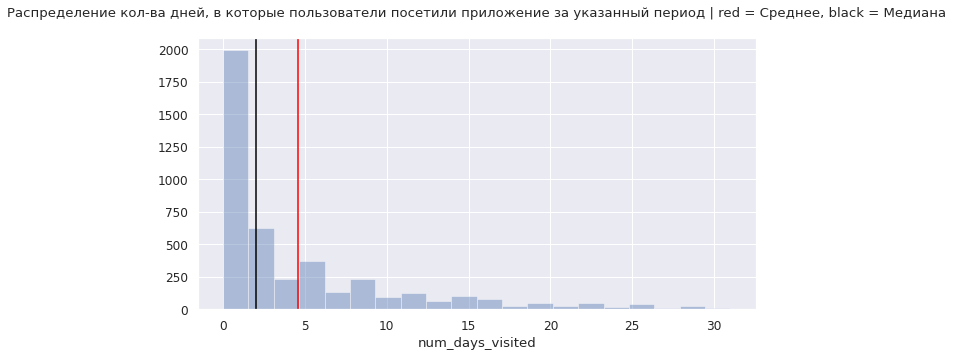

In [67]:
ax = sns.distplot(test['num_days_visited'], kde = False, bins = 20)
ax.set(title = 'Распределение кол-ва дней, в которые пользователи посетили приложение за указанный период | red = Среднее, black = Медиана\n')
plt.axvline(x = test['num_days_visited'].mean(), color = 'red')
plt.axvline(x = test['num_days_visited'].median(), color = 'black')
plt.show()

control_1

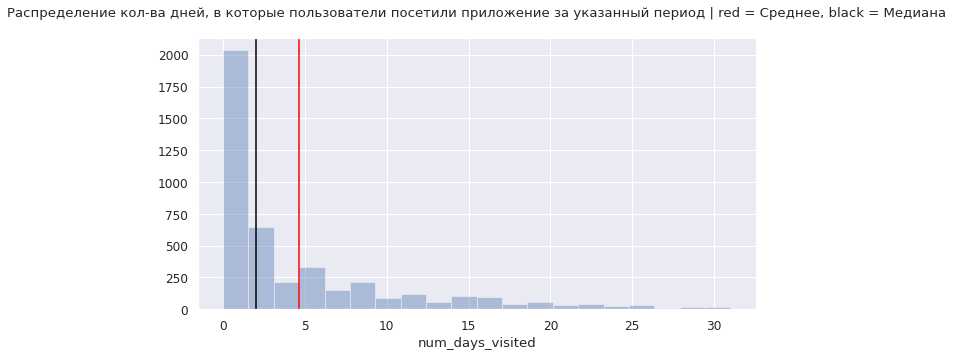

In [68]:
ax = sns.distplot(control_1['num_days_visited'], kde = False, bins = 20)
ax.set(title = 'Распределение кол-ва дней, в которые пользователи посетили приложение за указанный период | red = Среднее, black = Медиана\n')
plt.axvline(x = control_1['num_days_visited'].mean(), color = 'red')
plt.axvline(x = control_1['num_days_visited'].median(), color = 'black')
plt.show()

control_2

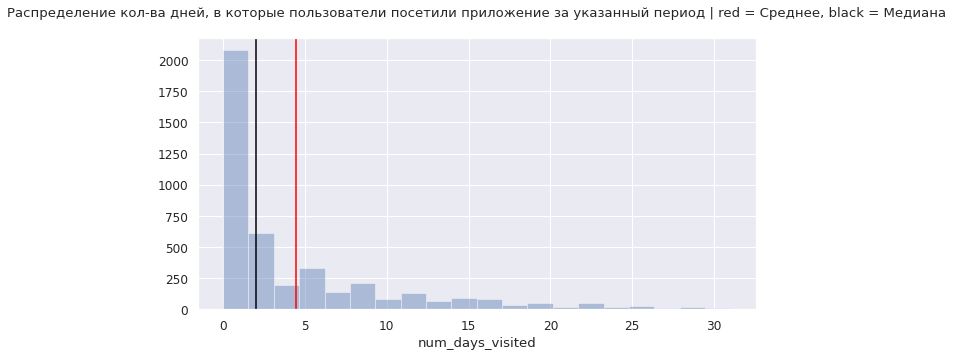

In [69]:
ax = sns.distplot(control_2['num_days_visited'], kde = False, bins = 20)
ax.set(title = 'Распределение кол-ва дней, в которые пользователи посетили приложение за указанный период | red = Среднее, black = Медиана\n')
plt.axvline(x = control_2['num_days_visited'].mean(), color = 'red')
plt.axvline(x = control_2['num_days_visited'].median(), color = 'black')
plt.show()

Распределения кол-ва дневных посетителей во всех трёх группах идентичны. Предполагаем, что считать метрики, завязанные на кол-ве дневных посещений пользователя не имеет смысла, так как визуально не наблюдаем значимых различий между группами.

### Предобработка
Для удобства сontrol_1 и control_2 соединим вместе и будем использовать общие данные двух контрольных групп против тестовых данных для оценки результатов A/B теста.

In [70]:
control = control_1.append(control_2, ignore_index=True)

test['experiment_group'] = 'test'
control['experiment_group'] = 'control'

all_df = test.append(control, ignore_index=True)

### Расчёт конверсии в подписку
Метрику ARPU мы можем вычислять по столбцу *revenue* и использовать её для оценки общего влияния внедрённого изменения на выручку со всех монетизированных механик продукта, но конверсию в целевое действие следует считать только по оформлению премиумной подписки - как конкретной механики, на которую направлено изменение.

Основной вопрос состоит в том, данные какого столбца использовать для расчёта конверсии. Наиболее простым способом будет взять данные столбца *was_premium* с "готовыми" конверсиями, но перед этим необходимо доказать, что это данные только за период проведения эксперимента, а не за всё время.

Докажем от противного - предположим, данные по конверсиям в премиум *was_premium* взяты за всё время существования сервиса. В этом случае *total_revenue* по пользователям также приведено за всё время. Но, как узнаём ниже, сумма *revenue* по транзакциям за время проведения эксперимента совпадает с *total_revenue* за исключением трёх конкретных случаев, которые можно связать с багом в записи данных - значит, *total_revenue* с пользователя расчитано только за время проведения эксперимента.

Соответственно, данные в столбце *was_premium* также взяты только за время проведения эксперимента, их можно использовать для расчёта конверсии в премиум-подписку в рамках оценки результатов A/B теста.

In [71]:
all_df[all_df['total_revenue'] != all_df['revenue']]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue,product_type_coins,product_type_other_type,product_type_premium_no_trial,product_type_trial_premium,num_days_visited,experiment_group
2070,892275462,31,310,0.0,France,"[1, 2, 3, 4, 5, 9, 13, 15, 16]",1,36,68,58,1.0,1.0,14885,58968.0,0.0,2.0,0.0,0.0,9,test
4818,960936960,30,4,99958.0,Russian Federation,"[1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, ...",1,26,62,4262,1.0,1.0,26,0.0,0.0,0.0,0.0,0.0,27,control
7678,892355163,40,640,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,25,60,700,1.0,0.0,0,30264.0,0.0,1.0,0.0,0.0,29,control


## A/A тест
Проверим систему сплитования сервиса. 

Сначала сделаем это по метрике ARPU (другими словами, по среднему в столбце *revenue*)

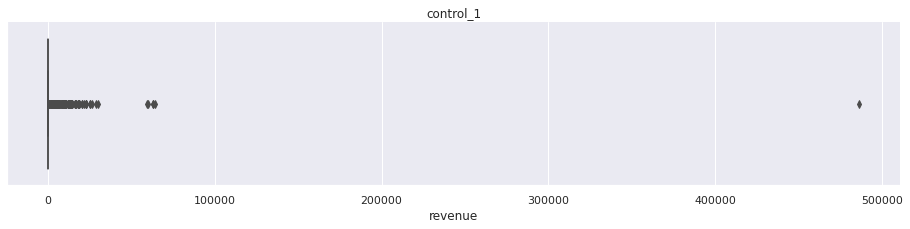

In [72]:
sns.set(rc = {'figure.figsize': (16, 3)})
sns.boxplot(data = control_1, x='revenue').set(title='control_1')
sns.despine()

In [73]:
pg.normality(control_1['revenue'])

,W,pval,normal
revenue,0.039849,0.0,False


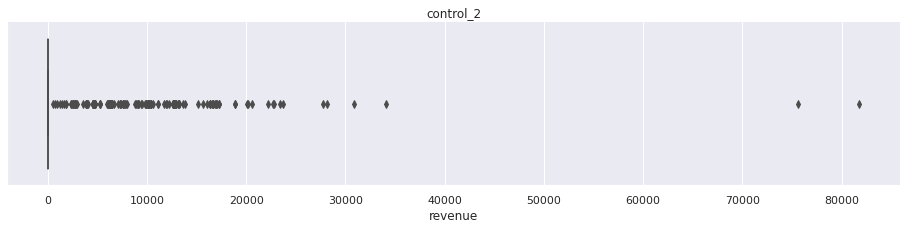

In [74]:
sns.set(rc = {'figure.figsize': (16, 3)})
sns.boxplot(data = control_2, x='revenue').set(title='control_2')
sns.despine()

In [75]:
sns.set(rc = {'figure.figsize': (10, 5)})

In [76]:
pg.normality(control_2['revenue'])

,W,pval,normal
revenue,0.144574,0.0,False


В обеих контрольных подвыборках наблюдаем существенные выбросы, распределения метрики ARPU статистически значимо отличается от нормального.

### Выбор статистического критерия (ARPU)
Как наиболее простое решение при проверке системы сплитования можем использовать **Т-критерий стьюдента**. Нормальность распределений при больших размерах выборок не является обязательным требованием для применения t-test'а - распределение средних таких выборок в конечном итоге всё равно будет принимать нормальный вид.

Для Т-критерия необходимо проконтролировать соблюдение другого важного требования: *дисперсии выборок должны быть гомогенны*. Проверим это с помощью критерия Левена

In [77]:
print(stats.levene(control_1['revenue'], control_2['revenue']))

LeveneResult(statistic=1.355716802475085, pvalue=0.24431346986802777)


Полученные p-value от теста на гомогенность дисперсий превышают дефолтный уровень альфа 0.05 - принимаем H0 и подтверждаем гомогенность дисперсий двух контрольных подвыборок. Все требования выполняются, для A/A теста по ARPU можем использовать **t-test**.

Определяем гипотезы по критерию Стьюдента и приступаем к реализации:

#### H0: ARPU статистически значимо не различается в двух контрольных подвыборках
#### H1: ARPU статзначимо различается

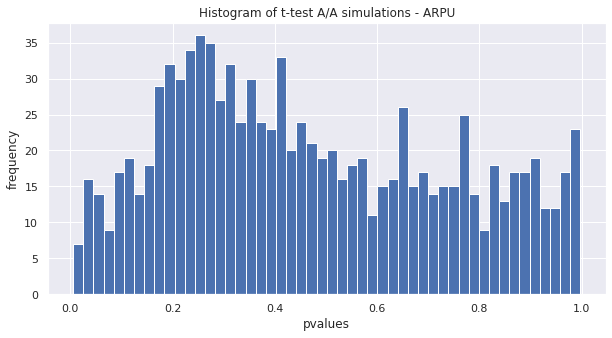

0.028

In [78]:
simulations = 1000 # Кол-во симуляций А/А теста
n_s = 1000 # Размер подвыборок
res = [] # Будем записывать результаты симуляций в переменную res

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = control_1['revenue'] \
        .sample(n_s, replace = False).values # Первая экспериментальная группа
    s2 = control_2['revenue'] \
        .sample(n_s, replace = False).values # Вторая экспериментальная группа
    res.append(stats.ttest_ind(s1, s2)[1])

plt.hist(res, bins = 50)
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of t-test A/A simulations - ARPU")
plt.show()

sum(np.array(res) < 0.05) / simulations

Получаем положительный результат: False Positive Rate < 0.05, нулевая гипотеза подтверждена - значения ARPU между двумя контрольными подвыборками значимо не различаются - система сплитования работает корректно. Теперь посчитаем A/A тест по конверсиям.

### Выбор статистического критерия (конверсии)
Также попробуем использовать Т-критерий. Проверим требования на гомогенность дисперсий аналогично с первым пунктом

In [79]:
print(stats.levene(control_1['was_premium'], control_2['was_premium']))

LeveneResult(statistic=0.4018495447507308, pvalue=0.5261524731759128)


Полученные p-value от применения критерия Левена превышают дефолтный уровень альфа 0.05 - принимаем H0 и подтверждаем гомогенность дисперсий двух контрольных подвыборок. Все требования выполняются, для A/A теста по конверсиям можем использовать **t-test**.

Определяем гипотезы по критерию Стьюдента и приступаем к реализации:

#### H0: Средние значения конверсии в премиум-подписку статистически значимо не различаются в двух контрольных подвыборках
#### H1: Средние значения конверсии в премиум-подписку статзначимо различаются

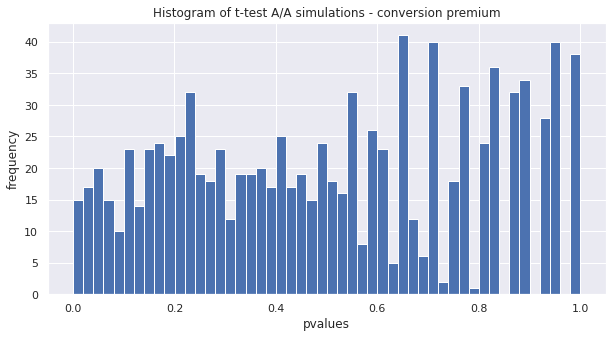

0.042

In [80]:
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = control_1['was_premium'] \
        .sample(n_s, replace = False).values
    s2 = control_2['was_premium'] \
        .sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2)[1])

plt.hist(res, bins = 50)
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of t-test A/A simulations - conversion premium")
plt.show()

sum(np.array(res) < 0.05) / simulations

Снова положительный результат: False Positive Rate < 0.05, нулевая гипотеза подтверждена - система сплитования в разрезе конверсий работает корректно

## A/B тест
Цель оценки результатов A/B теста - узнать, меняются ли в каких-то пользовательских сегментах и в целом показатели средней выручки на пользователя и конверсии в премиум-подписку из-за изменения цены подписки.

Предварительно просто посчитаем метрики, визуализируя их распредения, и поделим пользователей по группам

In [81]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12912 entries, 0 to 12911
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   uid                            12912 non-null  int64  
 1   age                            12912 non-null  int64  
 2   attraction_coeff               12912 non-null  int64  
 3   coins                          12912 non-null  float64
 4   country                        12912 non-null  object 
 5   visit_days                     8894 non-null   object 
 6   gender                         12912 non-null  int64  
 7   age_filter_start               12912 non-null  int64  
 8   age_filter_end                 12912 non-null  int64  
 9   views_count                    12912 non-null  int64  
 10  was_premium                    12912 non-null  float64
 11  is_premium                     12912 non-null  float64
 12  total_revenue                  12912 non-null 

In [82]:
all_df.groupby('experiment_group', as_index=False).agg({'revenue': 'mean'})

,experiment_group,revenue
0,control,526.725128
1,test,544.313138


In [83]:
all_df.groupby('experiment_group', as_index=False).agg({'was_premium': 'mean'})

,experiment_group,was_premium
0,control,0.098443
1,test,0.094708


Судя по данным, премиум-подписка могла подорожать - средняя выручка на пользователя стала слегка выше, но конверсии в премиум-подписку слегка снизились. A/B тест позволит проверить, насколько статзначимы эти изменения.

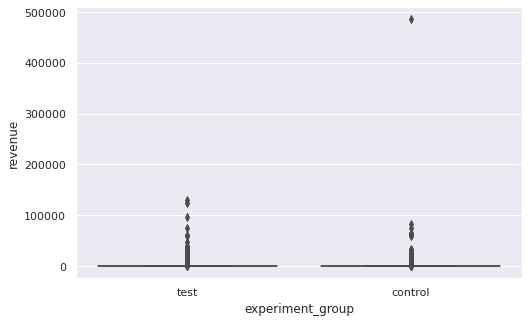

In [84]:
plt.figure(figsize = (8, 5))
sns.boxplot(data = all_df, x = 'experiment_group', y = 'revenue')
plt.show()

Отмечаем сильно вытянутые распределения по *ARPU* - есть множество значимых выбросов в правой части распределений двух групп. Подтвердим гипотезу, что распределения подвыборок не являются нормальными с помощью QQ-плота и normality-теста

#### H0 normality-теста: данные представляют собой нормальное распределение

<Figure size 720x432 with 0 Axes>

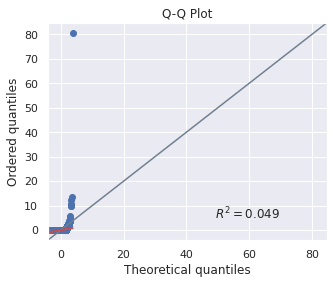

In [85]:
df_control_revenue = all_df.query("experiment_group == 'control'")['revenue']

plt.figure(figsize = (10, 6))
pg.qqplot(df_control_revenue)
plt.show()

т.к. для проведения теста на нормальность необходим размер выборки < 5000 наблюдений, для контрольной группы (N > 8000) ограничимся проверкой только на QQ-плоте

<Figure size 720x432 with 0 Axes>

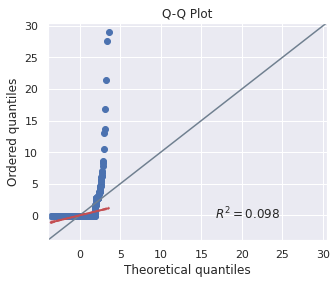

,W,pval,normal
revenue,0.099457,0.0,False


In [86]:
df_test_revenue = all_df.query("experiment_group == 'test'")['revenue']

plt.figure(figsize = (10, 6))
pg.qqplot(df_test_revenue)
plt.show()

pg.normality(df_test_revenue)

Отвергаем нулевую гипотезу о нормальности распределений выручки на пользователя в тестовой и контрольной подвыборках

### Гендер и страны
По наблюдениям из EDA это параметры, по которым проще всего сегментировать пользователей и в которых есть явные лидеры (мужчины / США) - приоритетные группы для рассмотрения решений о внедрении изменений в продукт

ARPU - гендер

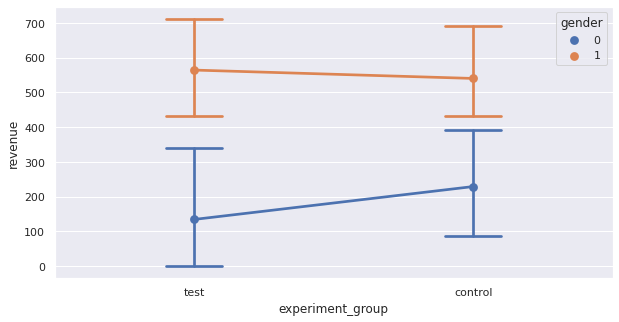

In [87]:
sns.pointplot(x='experiment_group', y='revenue', hue='gender', data=all_df, capsize=0.2)
plt.show()

Конверсия в премиум-подписку - гендер

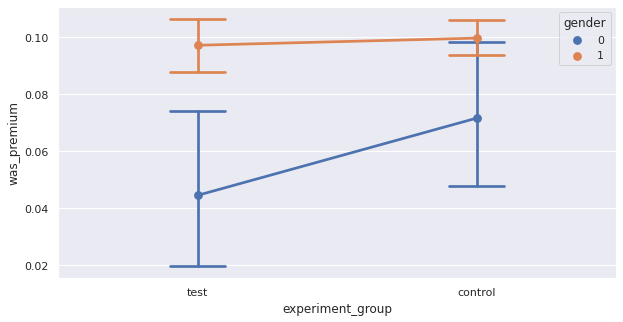

In [88]:
sns.pointplot(x='experiment_group', y='was_premium', hue='gender', data=all_df, capsize=0.2)
plt.show()

#### Промежуточные заметки
У мужчин в тесте повысилась ARPU и незначительно упала конверсия в премиум-подписку. Женщины более чувствительны к изменениям в цене подписки - ARPU и конверсии по результатам изменений резко упали.

In [89]:
top_5_country_list = all_df \
    .groupby('country', as_index=False) \
    .agg({'uid': 'count'}) \
    .nlargest(5, 'uid')['country'].tolist() # Возьмём топ-5 стран по пользователям во всей A1/A2/B выборке

df_top_5_country = all_df[all_df['country'].isin(top_5_country_list)]

ARPU - топ-5 стран

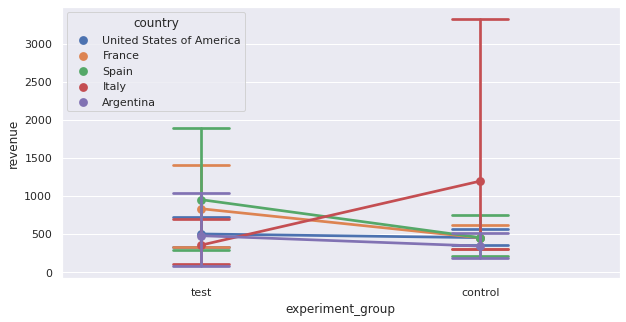

In [90]:
sns.pointplot(x='experiment_group', y='revenue', hue='country', data=df_top_5_country, capsize=0.2)
plt.show()

Конверсии в премиум-подписку - топ-5 стран

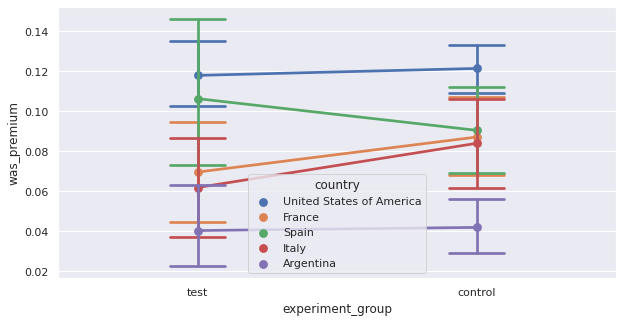

In [91]:
sns.pointplot(x='experiment_group', y='was_premium', hue='country', data=df_top_5_country, capsize=0.2)
plt.show()

#### Промежуточные заметки
Одновременно выросли ARPU и конверсии в подписку только у пользователей из Испании. На пользователей из США и Аргентины эксперимент значимо не повлиял, зато наблюдения вызвали преимущественно негативный отклик в Италии.

In [92]:
pd.crosstab(index = df_top_5_country.country,
            columns = df_top_5_country.gender,
            values = df_top_5_country.revenue,
            aggfunc = 'mean')

gender,0,1
country,,
Argentina,0.000000,385.493628
France,0.000000,580.077206
Italy,0.000000,921.395745
Spain,0.000000,615.176596
United States of America,153.603535,495.928447


In [93]:
pd.crosstab(index = df_top_5_country.country,
            columns = df_top_5_country.gender,
            values = df_top_5_country.was_premium,
            aggfunc = 'mean')

gender,0,1
country,,
Argentina,0.000000,0.041631
France,0.058824,0.081801
Italy,0.000000,0.077660
Spain,0.000000,0.096809
United States of America,0.058081,0.126402


Отмечаем очень большой дисбаланс в распределении пользователей женского пола по странам - если в США это 396 уникальных юзеров по которым получилось собрать какие-то данные по средней выручке и конверсиям, то в остальных топ-5 странах юзеры-девушки, которые приносят сервису выручку / оформляли подписку практически отсутствуют. Посмотрим метрики в тесте и контроле в срезе юзеров-мужчин из топ-5 стран.

In [94]:
df_top_5_country \
    .groupby(['country', 'experiment_group'], as_index=False) \
    .agg({'revenue': 'mean'}) \
    .pivot(index='country', columns='experiment_group', values='revenue')

experiment_group,control,test
country,,
Argentina,338.049618,474.795455
France,446.949062,829.247911
Italy,1192.847861,351.160991
Spain,449.138037,948.265781
United States of America,449.157254,497.819310


В некоторых странах ARPU среди мужчин существенно отросла, а в Италии наоборот резко упала. Не забываем, что это может быть связано с ненормальными распределениями ARPU в группах

In [95]:
df_top_5_country \
    .groupby(['country', 'experiment_group'], as_index=False) \
    .agg({'was_premium': 'mean'}) \
    .pivot(index='country', columns='experiment_group', values='was_premium')

experiment_group,control,test
country,,
Argentina,0.041985,0.040404
France,0.087131,0.069638
Italy,0.083994,0.061920
Spain,0.090491,0.106312
United States of America,0.121407,0.117931


Видим положительные изменения для мужчин в Испании по обеим метрикам. В целом изменения в конверсиях визуально не кажутся значительными.

### Генерация новых фичей (категорий) для сегментации пользователей
Помимо очевидной группировки по категориальным параметрам, мы можем вручную создать группы для сегментации пользователей и исследования изменения метрик в разрезе групп с помощью столбцов *age*, *attraction_coeff*, *coins*, *num_days_visited*.

**Почему именно такие группы?** Каждая группа соответствует определённой гипотезе или вопросу.

Во-первых, мы не зря игнорируем параметр даты и времени для сегментации пользователей - помним, что много дат было забаговано в таблицах *transactions*, что может привести нас к неправильному выводу при рассмотрении результатов A/B теста во временном разрезе.

Группы по *age* могут дать нам определённый инсайт о том, для каких возрастных групп повышение цены подписки влечёт за собой положительные ретёрны. Например, повышение цен для молодых (16-25) пользователей может резко отталкивать их от премиума - они в среднем зарабатывают меньше и могут быть сильно чувствительны к ценовым изменениям. Проверим.

Группы по *attraction_coeff* могут давать различные сценарии. Возможно, премиум-фичи не таргетируют более привлекательных пользователей, которым не так интересно подниматься вверх в дейтинговой выдаче, а наоборот, таргетируют менее привлекательных, кому действительно важно попадаться в выдаче чаще. В таком случае повышение цены может пагубно повлиять на выручку и конверсии в группе с высокой привлекательностью. Посмотрим, так ли это.

Группы по *coins* проверяют взаимосвязь изменения в цене с изменениями в метриках в разрезе параметра взаимодействия пользователя внутренней валютой продукта: Стали ли чаще покупать премиум (и/или приносить больше выручки) те, у кого есть внутренняя валюта?

Группы по *num_days_visited* позволят исследовать, влияют ли изменения в цене больше на более активных или менее активных пользователей.

In [96]:
all_df[['age', 'attraction_coeff', 'coins', 'num_days_visited', 'product_type_trial_premium']].describe()

,age,attraction_coeff,coins,num_days_visited,product_type_trial_premium
count,12912.000000,12912.000000,12912.000000,12912.00000,12912.000000
mean,32.010378,315.455545,9.070864,4.55855,0.014095
std,10.224415,323.488766,883.417344,6.22509,0.118544
min,16.000000,0.000000,0.000000,0.00000,0.000000
25%,25.000000,0.000000,0.000000,0.00000,0.000000
50%,30.000000,250.000000,0.000000,2.00000,0.000000
75%,38.000000,529.000000,0.000000,7.00000,0.000000
max,99.000000,1000.000000,99958.000000,31.00000,2.000000


4 группы *age* - 16-25, 25-30, 30-38, 38+

In [97]:
age_group = pd.cut(all_df.age, bins=[16, 25, 30, 38, 99], labels=['16-25', '25-30', '30-38', '38+'])
all_df.insert(2, 'age_group', age_group)

In [98]:
all_df.age_group.value_counts(normalize=True)

16-25    0.289867
38+      0.248717
30-38    0.239634
25-30    0.221783
Name: age_group, dtype: float64

4 группы *attraction_coeff* - non-viewed, 0-250, 250-529, 529+

In [99]:
def attraction_cluster(attraction_coeff, views_count):
    if attraction_coeff == 0 and views_count == 0:
        return 'non_viewed'
    elif views_count != 0 and attraction_coeff >= 0 and attraction_coeff < 250:
        return '0-250'
    elif attraction_coeff >= 250 and attraction_coeff < 529:
        return '250-529'
    else:
        return '529+'

In [100]:
all_df['attraction_group'] = all_df \
    .apply(lambda x: attraction_cluster(x.attraction_coeff, x.views_count), axis=1)

In [101]:
all_df.attraction_group.value_counts(normalize=True)

0-250         0.295074
250-529       0.251471
529+          0.250542
non_viewed    0.202912
Name: attraction_group, dtype: float64

2 группы *coins* - has coins, no coins

In [102]:
def coins_cluster(coins):
    if coins > 0:
        return 'has coins'
    else:
        return 'no coins'

In [103]:
all_df['coins_group'] = all_df['coins'].apply(coins_cluster)

In [104]:
all_df.coins_group.value_counts(normalize=True)

no coins     0.986834
has coins    0.013166
Name: coins_group, dtype: float64

3 группы *num_days_visited* - 0-1, 1-5, 5+

In [105]:
num_days_visited_group = pd.cut(all_df.num_days_visited, bins=[0, 1, 5, 31], labels=['0-1', '1-5', '5+'])
all_df.insert(20, 'num_days_visited_group', num_days_visited_group)

In [106]:
all_df.num_days_visited_group.value_counts(normalize=True)

5+     0.418597
1-5    0.347088
0-1    0.234315
Name: num_days_visited_group, dtype: float64

### Расчет метрик в разрезе новых параметров

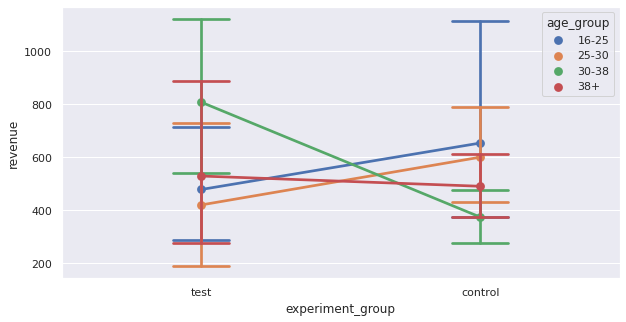

In [107]:
sns.pointplot(x='experiment_group', y='revenue', hue='age_group', data=all_df, capsize=0.2)
plt.show()

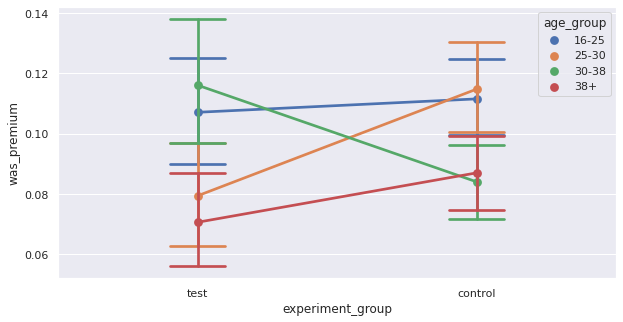

In [108]:
sns.pointplot(x='experiment_group', y='was_premium', hue='age_group', data=all_df, capsize=0.2)
plt.show()

ARPU показала улучшение в более возрастных группах - 30-38 и 38+. Конверсии серьёзно улучшились в 30-38. Гипотеза о возрастных группах может быть отчасти верна. Интересно посмотреть эту группу более детально в разрезе гендера и дневной активности.

In [109]:
df_age_30_38 = all_df.query("age_group == '30-38'")

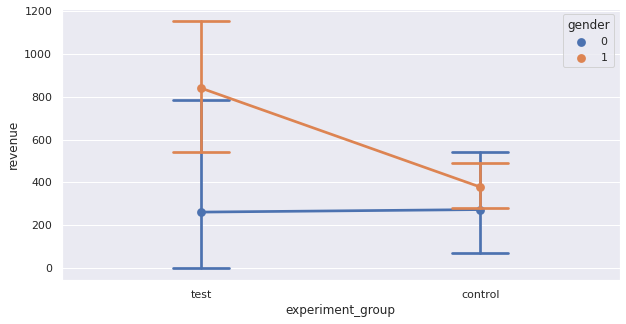

In [110]:
sns.pointplot(x='experiment_group', y='revenue', hue='gender', data=df_age_30_38, capsize=0.2)
plt.show()

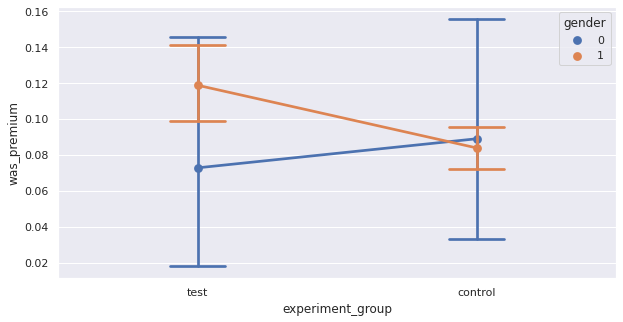

In [111]:
sns.pointplot(x='experiment_group', y='was_premium', hue='gender', data=df_age_30_38, capsize=0.2)
plt.show()

У пользователей-мужчин в этой группе действительно значительно отросли ARPU и конверсии!

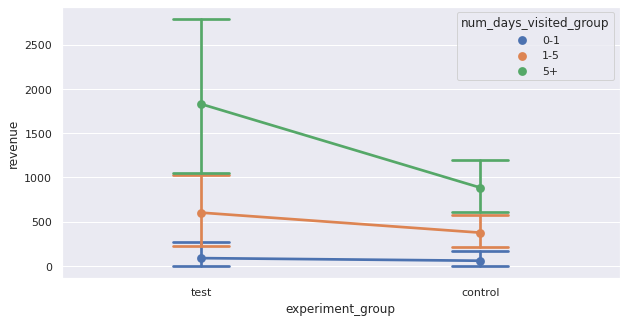

In [112]:
sns.pointplot(x='experiment_group', y='revenue', hue='num_days_visited_group', data=df_age_30_38, capsize=0.2)
plt.show()

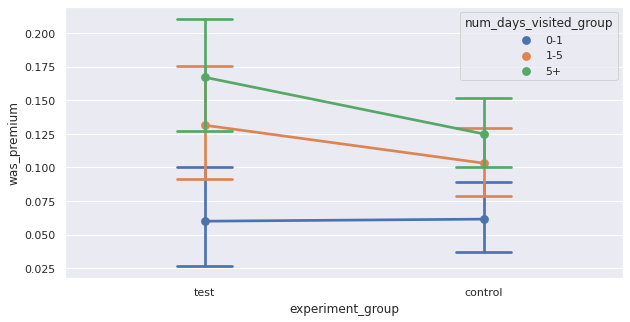

In [113]:
sns.pointplot(x='experiment_group', y='was_premium', hue='num_days_visited_group', data=df_age_30_38, capsize=0.2)
plt.show()

Получаем интересные выводы - чем выше дневная активность пользователей в возрастной группе 30-38, тем выше шанс, что они купят премиум и тем больше он вырос в тестовой группой по сравнению с контрольной.

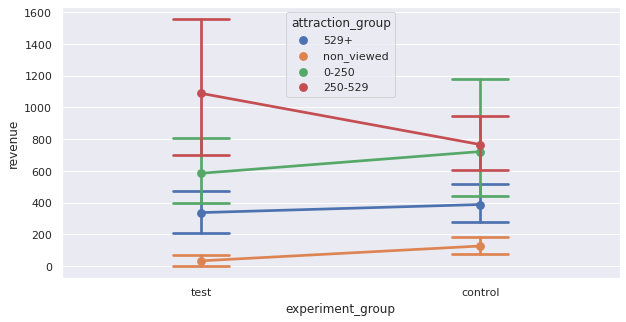

In [114]:
sns.pointplot(x='experiment_group', y='revenue', hue='attraction_group', data=all_df, capsize=0.2)
plt.show()

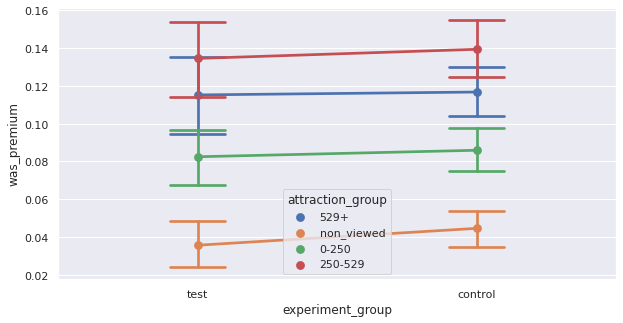

In [115]:
sns.pointplot(x='experiment_group', y='was_premium', hue='attraction_group', data=all_df, capsize=0.2)
plt.show()

Сильно отросла ARPU в группе "середнячков" по привлекательности, падение конверсий всех групп незначительно.

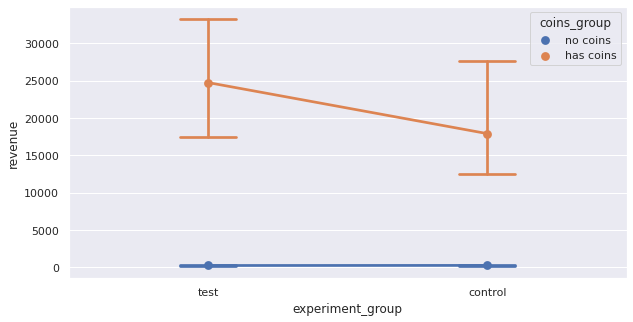

In [116]:
sns.pointplot(x='experiment_group', y='revenue', hue='coins_group', data=all_df, capsize=0.2)
plt.show()

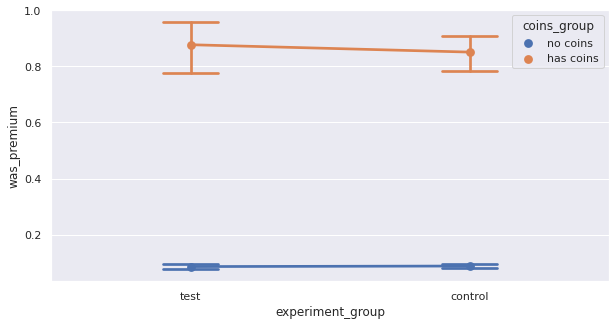

In [117]:
sns.pointplot(x='experiment_group', y='was_premium', hue='coins_group', data=all_df, capsize=0.2)
plt.show()

Пользователи, имеющие внутренние валюту, имеют близкие к 100% конверсии в премиум-подписку. Как и ожидалось, их ARPU и конверсия благоприятно изменяется в тесте по сравнению с контролем.

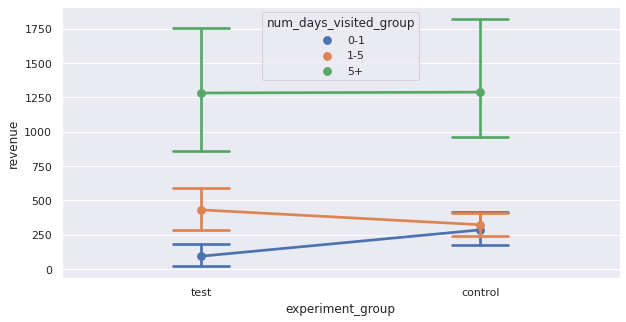

In [118]:
sns.pointplot(x='experiment_group', y='revenue', hue='num_days_visited_group', data=all_df, capsize=0.2)
plt.show()

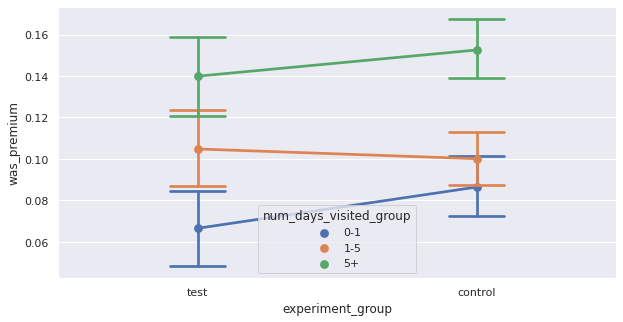

In [119]:
sns.pointplot(x='experiment_group', y='was_premium', hue='num_days_visited_group', data=all_df, capsize=0.2)
plt.show()

Метрики незначительно отросли для категории пользователей с 1-5 активных посещений, для остальных групп ухудшились

### Инсайты из визуального анализа срезов пользователей перед применением статметодов

1. Изменения по метрикам из контроля в тест по выборкам в целом выглядят незначительными.

2. Среди гендеров более позитивные изменения в показателях наблюдаются у мужчин.

3. Среди топ-5 стран ARPU незначительно повысилась в США, отмечаем рост метрик в Испании.

4. Повысились ARPU и конверсии в средневозрастном сегменте 30-38 лет. Особенно существенны положительные изменения в метриках, если в этом сегменте выделить мужчин и наиболее активных по дневным посещениям пользователей.

5. Фича может быть также релевантна для тех, кто либо имеет "средний" уровень привлекательности, либо имеет внутреннюю валюту.

6. Эксперимент может давать положительный эффект для бизнеса в рамках сегмента "1-5" по кол-ву дневных посещений сервиса.

Проверим на статметоде по обеим метрикам (ARPU + конверсия пользователя в премиум-подписку) все верхнеуровневые выделенные сегменты пользователей и те, что показали наиболее выдающиеся изменения по результатам предварительного анализа. По результатам этого упражнения оценим корректность внедрения фичи в продукт по каждому выделенному срезу.

### Выбор статметодов
**ARPU**

Мы проверили, что ARPU по общим данным в группах A и B статзначимо отличаются от нормального распределения. Для случаев, когда подвыборки имеют размер > 30 наблюдений и соблюдается требование о гомогенности дисперсий, можно использовать **t-test**. Перед применением критерия на каждый конкретный срез будем удостоверяться в том, что эти требования соблюдаются, а в противном случае искать и применять более подходящие статметоды.

Гипотезы по критерию Стьюдента:

**H0:** Значения ARPU в контрольной и тестовой подвыборках статистически значимо не различаются

**H1:** Значения ARPU значимо различаются

**Важно!** В случаях, где дисперсионная гомогенность не соблюдается, будем использовать **t-критерий Уэлча**. Он проверяет те же гипотезы, что и критерий Стьюдента, но не требует одинаковости дисперсий.

**Конверсия в премиум-подписку**

Для данных конверсии, имеющих распределение Бернулли, хорошо подойдёт **критерий Хи-Квадрат**. Он принимает на вход таблицу сопряжённости с двумя или более категориями и проверяет, зависит ли распределение заданной метрики от категории. В данном случае нашими категориями будут случаи конверсии (was_premium == 1) и отсутствия конверсии (was_premium == 0) пользователя в премиум-подписку. При применении критерия Хи-Квадрат основное требование - чтобы кол-во наблюдений в каждой категории превышало 5. Будем следить за его соблюдением для каждого среза. При этом если кол-во наблюдений в категории больше 5, но меньше 10, то необходимо использовать **поправку Йетса**. Также необходимо, чтобы анализируемые и сравниваемые между собой группы являлись независимыми, то есть не сравниваются результаты "до" и "после" - это соблюдается по дефолту для всех групп.

Гипотезы по критерию Хи-Квадрат:

**H0:** Распределение конверсий в премиум-подписку не зависит от категории

**H1:** Распределения конверсий в премиум-подписку статзначимо различаются

**Важно!** Для случаев, где кол-во N хотя бы в одной категории <= 5, необходимо использовать **точный тест Фишера**. Он также проверяет независимость категорий от определённого параметра, нуль-гипотеза останется прежняя.

Уровень значимости для проверки гипотез возьмём стандартный - 0.05.

Подготовка данных конверсий

In [120]:
all_df['was_premium'] = all_df['was_premium'].astype(int)

### Подготовка функций проверки требований и применения выбранных статкритериев

In [121]:
# Размер выборки > 30 для критерия Стьюдента (SS == Sample Size)
SSCheck = lambda A, B: 'требование N > 30 для t-test соблюдено' if (A > 30 and B > 30) else 'требование N > 30 для t-test не соблюдено'

# Гомогенность дисперсий для критерия Стьюдента (HoV == Homogeneity of Variances)
HoVCheck = lambda P: 'дисперсии подвыборок гомогенны' if (P >= 0.05) else 'гомогенность дисперсий подвыборок не соблюдается'

# Размер каждой категории более 5 наблюдений для критерия Хи-Квадрат
def CategorySizeCheck(all_sliced):

    cross_df = pd.crosstab(all_sliced['experiment_group'], all_sliced['was_premium'])
    print(f'\n{cross_df}')

    categories_list = [] # Список, куда будут записываться категории размером > 5

    for category_size in np.nditer(cross_df.values):
        if category_size.item(0) > 5:
            categories_list.append(category_size.item(0)) # Проверяем значения во всех категориях
            
    if cross_df.values.size == len(categories_list):
        print('\nРазмер каждой категории превышает 5, требование для критерия Хи-Квадрат соблюдено')
    else:
        print('\nТребование к размерам категорий > 5 для критерия Хи-Квадрат не соблюдено')

        
def AllRequirementCheck(all_sliced):
    
    control_sliced = all_sliced[all_sliced['experiment_group'] == 'control'] # контрольная подвыборка
    test_sliced    = all_sliced[all_sliced['experiment_group'] == 'test'] # тестовая подвыборка
    
    arpu_by_group = all_sliced \
        .groupby('experiment_group', as_index=False) \
        .agg({'revenue': 'mean'})
    print(arpu_by_group)
    
    SampleSizeA = control_sliced['revenue'].shape[0]
    SampleSizeB = test_sliced['revenue'].shape[0]
    
    print(f'\nРазмеры подвыборок по срезу:\nКонтрольная: N = {SampleSizeA};\nТестовая: N = {SampleSizeB};\nВывод: {SSCheck(SampleSizeA, SampleSizeB)}')

    stat, pval = stats.levene(control_sliced['revenue'], test_sliced['revenue'])
    print(f'\nРезультат применения критерия Левена на ARPU: p-value = {np.round(pval, 2)}, {HoVCheck(pval)}')

    CategorySizeCheck(all_sliced)

    
def ABTestFramework(all_sliced, Student=True, Welch=False, ChiSquare=True, Yates=False, FisherExact=False):
    
    control_sliced = all_sliced[all_sliced['experiment_group'] == 'control'] # контрольная подвыборка
    test_sliced    = all_sliced[all_sliced['experiment_group'] == 'test'] # тестовая подвыборка    
    
    
    if Student == True:
        stat, p_value1 = stats.ttest_ind(control_sliced['revenue'], test_sliced['revenue']) # t-критерий Стьюдента
        print(f'Результат применения t-критерия Стьюдента на ARPU: p-value = {np.round(p_value1, 2)}')
    
    if Welch == True:
        stat, p_value2 = stats.ttest_ind(control_sliced['revenue'], test_sliced['revenue'], equal_var=False) # t-критерий Уэлча
        print(f'Результат применения t-критерия Уэлча на ARPU: p-value = {np.round(p_value2, 2)}')

        
    cross_df = pd.crosstab(all_sliced['experiment_group'], all_sliced['was_premium'])
    
    if ChiSquare == True:
        stat, p_value3, _, _ = stats.chi2_contingency(cross_df) # критерий Хи-Квадрат
        print(f'\nРезультат применения критерия Хи-квадрат на конверсии в премиум-подписку: p-value = {np.round(p_value3, 2)}')
        
    if Yates == True:
        stat, p_value4, _, _ = stats.chi2_contingency(cross_df, correction=True) # критерий Хи-Квадрат с поправкой Йетса
        print(f'\nРезультат применения критерия Хи-квадрат с поправкой Йетса на конверсии в премиум-подписку: p-value = {np.round(p_value4, 2)}')
    
    if FisherExact == True:
        stat, p_value5 = stats.fisher_exact(cross_df) # точный тест Фишера
        print(f'\nРезультат применения точного теста Фишера на конверсии в премиум-подписку: p-value = {np.round(p_value5, 2)}')

### 1) A/B на полных данных без разрезов

In [122]:
AllRequirementCheck(all_df)

  experiment_group     revenue
0          control  526.725128
1             test  544.313138

Размеры подвыборок по срезу:
Контрольная: N = 8604;
Тестовая: N = 4308;
Вывод: требование N > 30 для t-test соблюдено

Результат применения критерия Левена на ARPU: p-value = 0.87, дисперсии подвыборок гомогенны

was_premium          0    1
experiment_group           
control           7757  847
test              3900  408

Размер каждой категории превышает 5, требование для критерия Хи-Квадрат соблюдено


**Все требования соблюдены**, можем использовать выбранные статметоды

*далее при соблюдении требований эта формулировка будет опущена*

In [123]:
ABTestFramework(all_df)

Результат применения t-критерия Стьюдента на ARPU: p-value = 0.87

Результат применения критерия Хи-квадрат на конверсии в премиум-подписку: p-value = 0.52


Значения ARPU согласно t-test'у в двух подвыборках статзначимо не различаются (p-value > 0.05, нуль-гипотезу принимаем).

Принимаем H0 по критерию Хи-квадрат - распределения категорий (converted users / non-converted users) согласно критерию Хи-квадрат значимо не различаются.

**Итого:** ARPU статзначимо не изменилось, различия между категориями по конверсиям также незначимые. По итогам статтестов на всю аудиторию продукта изменения раскатывать не следует.

### 2) A/B  по пользователям мужского пола

In [124]:
all_male = all_df.query("gender == 1")
AllRequirementCheck(all_male)

  experiment_group     revenue
0          control  540.376200
1             test  564.496347

Размеры подвыборок по срезу:
Контрольная: N = 8227;
Тестовая: N = 4106;
Вывод: требование N > 30 для t-test соблюдено

Результат применения критерия Левена на ARPU: p-value = 0.82, дисперсии подвыборок гомогенны

was_premium          0    1
experiment_group           
control           7407  820
test              3707  399

Размер каждой категории превышает 5, требование для критерия Хи-Квадрат соблюдено


In [125]:
ABTestFramework(all_male)

Результат применения t-критерия Стьюдента на ARPU: p-value = 0.82

Результат применения критерия Хи-квадрат на конверсии в премиум-подписку: p-value = 0.68


Поскольку мужчины составляют более 95% всей выборки пользователей эксперимента, значения p-value по тестам сильно не отличаются от результатов применения статметодов на общих данных. Принимаем H0 по T-тесту. В конверсиях в премиум-подписку также не наблюдаем статзначимых различий между категориями.

**Итого:** На сегмент пользователей мужского пола изменения не раскатываем.

### 3) A/B  по пользователям из США

In [126]:
all_usa = all_df.query("country == 'United States of America'")
AllRequirementCheck(all_usa)

  experiment_group     revenue
0          control  449.157254
1             test  497.819310

Размеры подвыборок по срезу:
Контрольная: N = 2957;
Тестовая: N = 1450;
Вывод: требование N > 30 для t-test соблюдено

Результат применения критерия Левена на ARPU: p-value = 0.62, дисперсии подвыборок гомогенны

was_premium          0    1
experiment_group           
control           2598  359
test              1279  171

Размер каждой категории превышает 5, требование для критерия Хи-Квадрат соблюдено


In [127]:
ABTestFramework(all_usa)

Результат применения t-критерия Стьюдента на ARPU: p-value = 0.62

Результат применения критерия Хи-квадрат на конверсии в премиум-подписку: p-value = 0.78


Принимаем H0 о равенстве средних по средней выручке с пользователя. Между конверсионной и неконверсионной категориями также не наблюдаем статзначимой разницы, принимаем H0 по критерию Хи-квадрат.

**Итого:** на группу пользователей из США изменения в платёжной системе не раскатываем

### 4) A/B по пользователям из Испании

In [128]:
all_spain = all_df.query("country == 'Spain'")
AllRequirementCheck(all_spain)

  experiment_group     revenue
0          control  449.138037
1             test  948.265781

Размеры подвыборок по срезу:
Контрольная: N = 652;
Тестовая: N = 301;
Вывод: требование N > 30 для t-test соблюдено

Результат применения критерия Левена на ARPU: p-value = 0.19, дисперсии подвыборок гомогенны

was_premium         0   1
experiment_group         
control           593  59
test              269  32

Размер каждой категории превышает 5, требование для критерия Хи-Квадрат соблюдено


In [129]:
ABTestFramework(all_spain)

Результат применения t-критерия Стьюдента на ARPU: p-value = 0.19

Результат применения критерия Хи-квадрат на конверсии в премиум-подписку: p-value = 0.51


Принимаем H0 по всем тестам: ARPU в подвыборках статзначимо не различается, в категориях по конверсии не наблюдаем различий.

**Итого**: на группу пользователей из Испании изменения в платёжной системе не раскатываем

### 5) A/B по пользователям в возрастных сегментах 30+

In [130]:
relevant_age_group = ['30-38', '38+']
all_30 = all_df.loc[all_df['age_group'].isin(relevant_age_group)]
AllRequirementCheck(all_30)

  experiment_group     revenue
0          control  432.862410
1             test  665.909493

Размеры подвыборок по срезу:
Контрольная: N = 4150;
Тестовая: N = 2033;
Вывод: требование N > 30 для t-test соблюдено

Результат применения критерия Левена на ARPU: p-value = 0.01, гомогенность дисперсий подвыборок не соблюдается

was_premium          0    1
experiment_group           
control           3795  355
test              1844  189

Размер каждой категории превышает 5, требование для критерия Хи-Квадрат соблюдено


*В этом сегменте не соблюдается гомогенность дисперсий - будем использовать t-критерий Уэлча вместо критерия Стьюдента*

In [131]:
ABTestFramework(all_30, Student=False, Welch=True)

Результат применения t-критерия Уэлча на ARPU: p-value = 0.04

Результат применения критерия Хи-квадрат на конверсии в премиум-подписку: p-value = 0.36


В этом срезе наконец отвергаем H0 для ARPU по критерию Уэлча. Значит, значения ARPU по этому разрезу впервые среди выделенных групп статзначимо различается в тесте по сравнению с контролем. По Хи-квадрату H0 принимаем, категории не различаются.

**Итого**: В этом сегменте мы добились существенного изменения ARPU, но на конверсии изменения значимо не повлияли. Имеет смысл поискать более интересный сегмент пользователей, где изменения привели к статзначимому результату по обеим метрикам

### 6) A/B по пользователям в возрастном сегменте 30-38

In [132]:
all_30_38 = all_df.loc[all_df['age_group'] == '30-38']
AllRequirementCheck(all_30_38)

  experiment_group     revenue
0          control  373.454545
1             test  807.977978

Размеры подвыборок по срезу:
Контрольная: N = 2035;
Тестовая: N = 999;
Вывод: требование N > 30 для t-test соблюдено

Результат применения критерия Левена на ARPU: p-value = 0.0, гомогенность дисперсий подвыборок не соблюдается

was_premium          0    1
experiment_group           
control           1864  171
test               883  116

Размер каждой категории превышает 5, требование для критерия Хи-Квадрат соблюдено


*Снова не соблюдается гомогенность дисперсий - используем тест Уэлча*

In [133]:
ABTestFramework(all_30_38, Student=False, Welch=True)

Результат применения t-критерия Уэлча на ARPU: p-value = 0.01

Результат применения критерия Хи-квадрат на конверсии в премиум-подписку: p-value = 0.01


Отвергаем H0 по критериям для обеих метрик! В этой группе значимо увеличилась ARPU и есть статзначимые изменения по категориям конверсии пользователей.

**Итого**: изменения имеют значимый положительный эффект на возрастной сегмент сервиса 30-38 лет. Какой конкретно? Посчитаем.

In [134]:
arpu_mean_test    = all_30_38[all_30_38['experiment_group'] == 'test']['revenue'].mean()
arpu_mean_control = all_30_38[all_30_38['experiment_group'] == 'control']['revenue'].mean()

conversion_mean_test    = all_30_38[all_30_38['experiment_group'] == 'test']['was_premium'].mean()
conversion_mean_control = all_30_38[all_30_38['experiment_group'] == 'control']['was_premium'].mean()

growth_coef_revenue = np.round(arpu_mean_test / arpu_mean_control, 2)
growth_coef_conversion = np.round(conversion_mean_test / conversion_mean_control, 2)

print(f'Благодаря изменениям ARPU в среднем выросла в {growth_coef_revenue} раза в возрастной группе 30-38 лет')
print(f'Благодаря изменениям конверсия в премиум-подписку в среднем выросла в {growth_coef_conversion} раза в возрастной группе 30-38 лет')

Благодаря изменениям ARPU в среднем выросла в 2.16 раза в возрастной группе 30-38 лет
Благодаря изменениям конверсия в премиум-подписку в среднем выросла в 1.38 раза в возрастной группе 30-38 лет


### 7) A/B по пользователям-мужчинам в возрастном сегменте 30-38
Углубимся на уровень ниже - посмотрим, выше ли статзначимость в сегменте мужчин в возрасте 30-38 лет

In [135]:
all_30_38_male = all_30_38[all_30_38['gender'] == 1]
AllRequirementCheck(all_30_38_male)

  experiment_group     revenue
0          control  378.116195
1             test  839.849576

Размеры подвыборок по срезу:
Контрольная: N = 1945;
Тестовая: N = 944;
Вывод: требование N > 30 для t-test соблюдено

Результат применения критерия Левена на ARPU: p-value = 0.0, гомогенность дисперсий подвыборок не соблюдается

was_premium          0    1
experiment_group           
control           1782  163
test               832  112

Размер каждой категории превышает 5, требование для критерия Хи-Квадрат соблюдено


*Не соблюдается гомогенность дисперсий - тест Уэлча*

In [136]:
ABTestFramework(all_30_38_male, Student=False, Welch=True)

Результат применения t-критерия Уэлча на ARPU: p-value = 0.01

Результат применения критерия Хи-квадрат на конверсии в премиум-подписку: p-value = 0.0


**Итого**: Альтернативно с внедрением фичи в сервис на всех пользователей в возрасте от 30 до 38 лет, для ещё более значимого эффекта мы можем раскатать эти изменения только на мужскую аудиторию этого возрастного сегмента - показатели по конверсии там показывают еще более значимые улучшения в тесте по сравнению с контролем.

In [137]:
arpu_mean_test    = all_30_38_male[all_30_38_male['experiment_group'] == 'test']['revenue'].mean()
arpu_mean_control = all_30_38_male[all_30_38_male['experiment_group'] == 'control']['revenue'].mean()

conversion_mean_test    = all_30_38_male[all_30_38_male['experiment_group'] == 'test']['was_premium'].mean()
conversion_mean_control = all_30_38_male[all_30_38_male['experiment_group'] == 'control']['was_premium'].mean()

growth_coef_revenue = np.round(arpu_mean_test / arpu_mean_control, 2)
growth_coef_conversion = np.round(conversion_mean_test / conversion_mean_control, 2)

print(f'Благодаря изменениям ARPU в среднем выросла в {growth_coef_revenue} раза среди мужчин в возрастной группе 30-38 лет')
print(f'Благодаря изменениям конверсия в премиум-подписку в среднем выросла в {growth_coef_conversion} раза среди мужчин в возрастной группе 30-38 лет')

Благодаря изменениям ARPU в среднем выросла в 2.22 раза среди мужчин в возрастной группе 30-38 лет
Благодаря изменениям конверсия в премиум-подписку в среднем выросла в 1.42 раза среди мужчин в возрастной группе 30-38 лет


In [138]:
male_30_38_proportion = np.round((all_30_38_male.shape[0] / all_df.shape[0]) * 100, 1)

print(f'Доля этого сегмента среди всех пользователей продукта составляет {male_30_38_proportion}%')

Доля этого сегмента среди всех пользователей продукта составляет 22.4%


### 8) A/B по пользователям-женщинам в возрастном сегменте 30-38

In [139]:
all_30_38_female = all_30_38[all_30_38['gender'] == 0]
AllRequirementCheck(all_30_38_female)

  experiment_group     revenue
0          control  272.711111
1             test  260.945455

Размеры подвыборок по срезу:
Контрольная: N = 90;
Тестовая: N = 55;
Вывод: требование N > 30 для t-test соблюдено

Результат применения критерия Левена на ARPU: p-value = 0.96, дисперсии подвыборок гомогенны

was_premium        0  1
experiment_group       
control           82  8
test              51  4

Требование к размерам категорий > 5 для критерия Хи-Квадрат не соблюдено


*В этом срезе не соблюдается требование к размеру категорий для применения критерия Хи-Квадрат (есть категория размером <= 5). Для этого кейса подойдёт точный тест Фишера*

In [140]:
ABTestFramework(all_30_38_female, ChiSquare=False, FisherExact=True)

Результат применения t-критерия Стьюдента на ARPU: p-value = 0.96

Результат применения точного теста Фишера на конверсии в премиум-подписку: p-value = 1.0


**Итого:** Видим, что раскатка изменений на женщинах в возрасте от 30 до 38 не даёт значимых эффектов с точки зрения ARPU и конверсии в премиум-подписку. Делаем вывод, что изменения следует раскатывать только на мужчинах в этой возрастной категории.

### 9) A/B по пользователям в возрастном сегменте 30-38 и кол-вом дневных посещений сервиса > 5

In [141]:
all_30_38_visits_5 = all_30_38[all_30_38['num_days_visited_group'] == '5+']
AllRequirementCheck(all_30_38_visits_5)

  experiment_group      revenue
0          control   884.888333
1             test  1828.695652

Размеры подвыборок по срезу:
Контрольная: N = 600;
Тестовая: N = 299;
Вывод: требование N > 30 для t-test соблюдено

Результат применения критерия Левена на ARPU: p-value = 0.01, гомогенность дисперсий подвыборок не соблюдается

was_premium         0   1
experiment_group         
control           525  75
test              249  50

Размер каждой категории превышает 5, требование для критерия Хи-Квадрат соблюдено


*Дисперсии подвыборок неодинаковы - заменяем тест Стьюдента на тест Уэлча*

In [142]:
ABTestFramework(all_30_38_visits_5, Student=False, Welch=True)

Результат применения t-критерия Уэлча на ARPU: p-value = 0.05

Результат применения критерия Хи-квадрат на конверсии в премиум-подписку: p-value = 0.1


**Итого**: "Углубление" из среднего возрастного сегмента 30-38 на уровень пользователей, наиболее часто посещающих сервис, не даёт таких значимых изменений по ARPU и конверсиям, как исходный сегмент.  Изменения отдельно на эту группу раскатывать не будем - внедрение изменений только для мужчин в возрасте от 30 до 38 даёт более значимые результаты.

### 10) A/B по пользователям со "средним" показателем привлекательности (250-529)

In [143]:
all_attract_250_529 = all_df[all_df['attraction_group'] == '250-529']
AllRequirementCheck(all_attract_250_529)

  experiment_group      revenue
0          control   765.728862
1             test  1088.640708

Размеры подвыборок по срезу:
Контрольная: N = 2117;
Тестовая: N = 1130;
Вывод: требование N > 30 для t-test соблюдено

Результат применения критерия Левена на ARPU: p-value = 0.1, дисперсии подвыборок гомогенны

was_premium          0    1
experiment_group           
control           1822  295
test               978  152

Размер каждой категории превышает 5, требование для критерия Хи-Квадрат соблюдено


In [144]:
ABTestFramework(all_attract_250_529)

Результат применения t-критерия Стьюдента на ARPU: p-value = 0.1

Результат применения критерия Хи-квадрат на конверсии в премиум-подписку: p-value = 0.74


Изменения по ARPU в тесте по сравнению с контролем были близки к статзначимым, но нулевую гипотезу всё равно принимаем, p-value слегка превышает уровень значимости 0.05. Хи-квадрат не показал значимых различий между сегментами по конверсиям.

**Итого:** не раскатываем изменения на сегмент пользователей со средней привлекательностью (диапазон коэффициента 250-529)

### 11) A/B по пользователям, имеющим внутреннюю валюту (монеты)

In [145]:
all_has_coins = all_df[all_df['coins_group'] == 'has coins']
AllRequirementCheck(all_has_coins)

  experiment_group       revenue
0          control  17901.859504
1             test  24722.551020

Размеры подвыборок по срезу:
Контрольная: N = 121;
Тестовая: N = 49;
Вывод: требование N > 30 для t-test соблюдено

Результат применения критерия Левена на ARPU: p-value = 0.47, дисперсии подвыборок гомогенны

was_premium        0    1
experiment_group         
control           18  103
test               6   43

Размер каждой категории превышает 5, требование для критерия Хи-Квадрат соблюдено


*В данном случае все требования для выбранных критериев соблюдаются, но требуется поправка Йетса для критерия Хи-Квадрат, так как размер одной из категорий находится в диапазоне от 5 до 10*

In [146]:
ABTestFramework(all_has_coins, ChiSquare=False, Yates=True)

Результат применения t-критерия Стьюдента на ARPU: p-value = 0.33

Результат применения критерия Хи-квадрат с поправкой Йетса на конверсии в премиум-подписку: p-value = 0.84


Выбранные критерии не показывают статзначимых изменений в метриках по срезу пользователей с внутренней валютой.

**Итого:** не раскатываем изменения на сегмент пользователей с внутренней валютой

### 12) A/B по пользователям со "средней дневной активностью" (кол-вом дневных посещений сервиса 1-5)

In [147]:
all_visits_1_5 = all_df[all_df['num_days_visited_group'] == '1-5']
AllRequirementCheck(all_visits_1_5)

  experiment_group     revenue
0          control  321.961538
1             test  430.276676

Размеры подвыборок по срезу:
Контрольная: N = 2028;
Тестовая: N = 1059;
Вывод: требование N > 30 для t-test соблюдено

Результат применения критерия Левена на ARPU: p-value = 0.18, дисперсии подвыборок гомогенны

was_premium          0    1
experiment_group           
control           1825  203
test               948  111

Размер каждой категории превышает 5, требование для критерия Хи-Квадрат соблюдено


In [148]:
ABTestFramework(all_visits_1_5)

Результат применения t-критерия Стьюдента на ARPU: p-value = 0.18

Результат применения критерия Хи-квадрат на конверсии в премиум-подписку: p-value = 0.73


Принимаем H0 по выбранным критериям.

**Итого**: не внедряем фичу на сегмент пользователей со средней дневной активностью

## Выводы

По итогам A/B теста можно сказать, что на всех пользователях и в большинстве пользовательских сегментов изменение стоимости премиум-подписки при покупке через две новые платёжные системы не даёт значимого положительного эффекта по метрикам ARPU и конверсии в премиум-подписку.

Несмотря на это, благодаря группировке пользователей получилось выделить сегмент, в котором такое изменение будет приносить выгоду для бизнеса в виде дополнительной выручки с пользователя и увеличенных конверсий. Это категория **пользователей-мужчин в возрасте от 30 до 38 лет**.

Доля пользователей этого сегмента среди всех пользователей продукта составляет **~22.4%**. В этом сегменте **в 2.22 раза (+122%)** выросла средняя выручка с пользователя и **в 1.42 раза (+42%)** выросла конверсия в покупку премиум-подписки, по результатам проверки метрик на статитисческих критериях такие изменения оказались статистически значимыми.

Новую фичу, связанную с изменением стоимости подписки в двух новых платёжных системах, стоит раскатить исключительно на этот сегмент аудитории приложения, остальные рассмотренные сегменты не должны быть затронуты, поскольку не дают статистически значимого положительного изменения метрик.